# Tutorial II: (Naive) data analysis and mock injection

In this tutorial, I show the workflow of a power spectrum analysis that is similar to our fiducial GAMA cross analysis.

Note that validation and optimisation are still ongoing so this is only a demonstration of the workflow and not a final analysis.

In [1]:
from meer21cm import PowerSpectrum, MockSimulation
import matplotlib.pyplot as plt
import numpy as np
from meer21cm.util import pcaclean, freq_to_redshift, redshift_to_freq
from meer21cm.telescope import dish_beam_sigma
from meer21cm.util import center_to_edges
from meer21cm.plot import plot_map, plot_pixels_along_los, plot_eigenspectrum



/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


## Step 1: Reading the data

In [2]:
file_dir = '/Users/zhaotingchen/Desktop/work/sd_stacking/'
# in ilifu use the following path
# file_dir = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
fits_file = file_dir+'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
counts_file = file_dir+'Nscan961_Npix_count_cube_p0.3d_sigma4.0_iter2.fits'
gal_file = file_dir+'G23TilingCatv11.fits'
# I forgot the path for gal file in ilifu, please check it

ps = PowerSpectrum(
    map_file=fits_file,
    counts_file=counts_file,
    gal_file=gal_file,
    beam_model='gaussian',
    beam_type='isotropic',
)
# read in map_file
ps.read_from_fits()
# read in galaxy file
ps.read_gal_cat()

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


You can visualise what you read in:

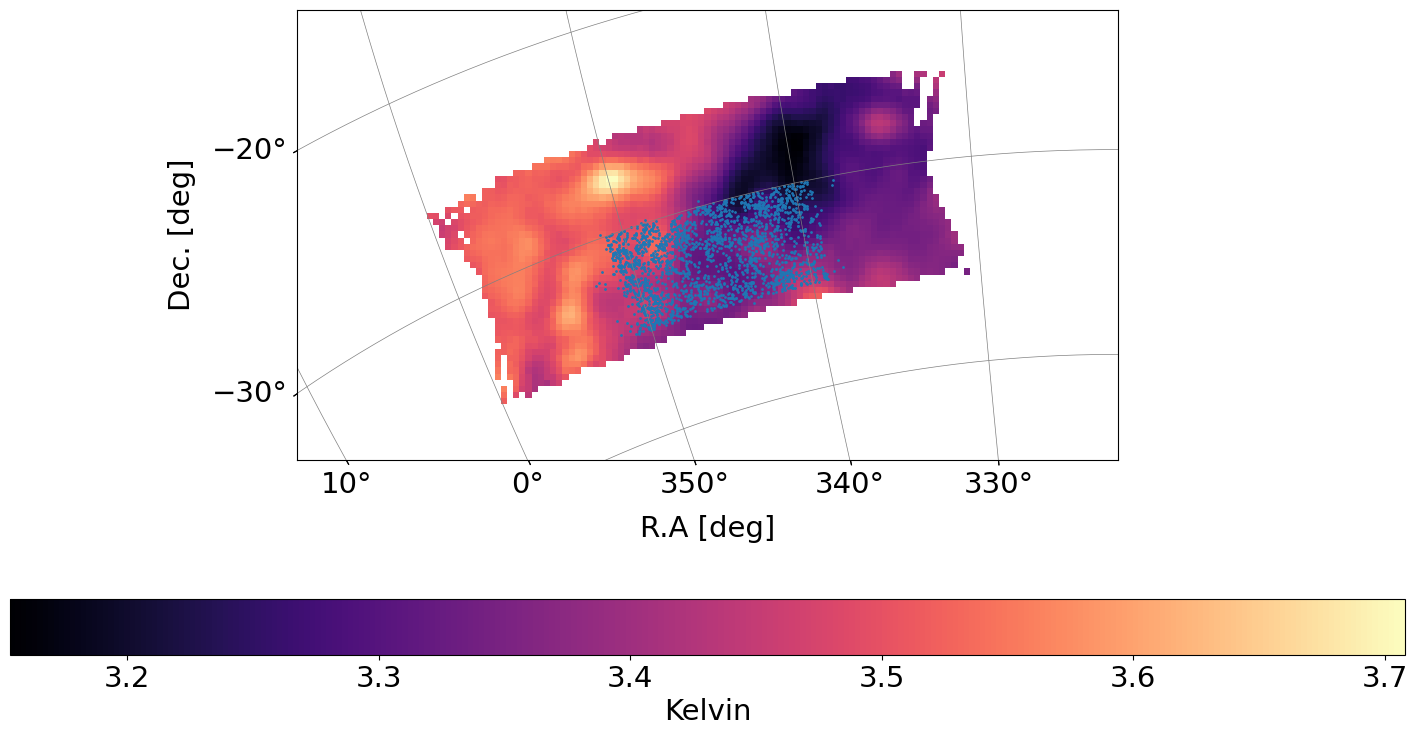

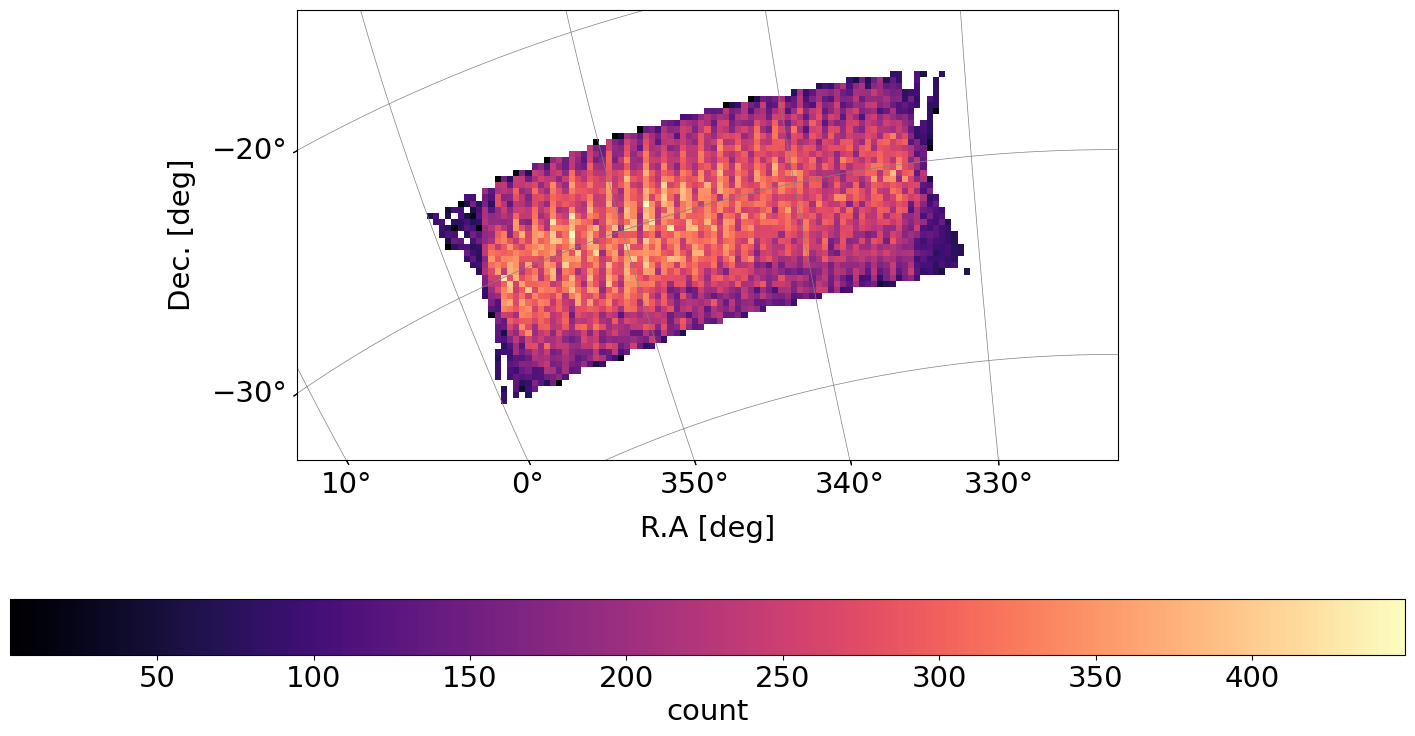

In [3]:
plt.rcParams.update({'font.size': 21})
plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
ax = plt.gca()
ax.scatter(
    ps.ra_gal,
    ps.dec_gal,
    transform=ax.get_transform('world'),
    s=1,
    alpha=1,
)
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,cbar_label='count')

## Step 2: Trimming the edges

In [4]:
ra_range_MK = (334, 357)
dec_range_MK = (-35, -26.5)
ra_range_GAMA = (339,351)
dec_range_GAMA = (-35,-30)
ps.ra_range = ra_range_GAMA
ps.dec_range = dec_range_GAMA
ps.trim_gal_to_range()
ps.ra_range = ra_range_MK
ps.dec_range = dec_range_MK
ps.trim_map_to_range()

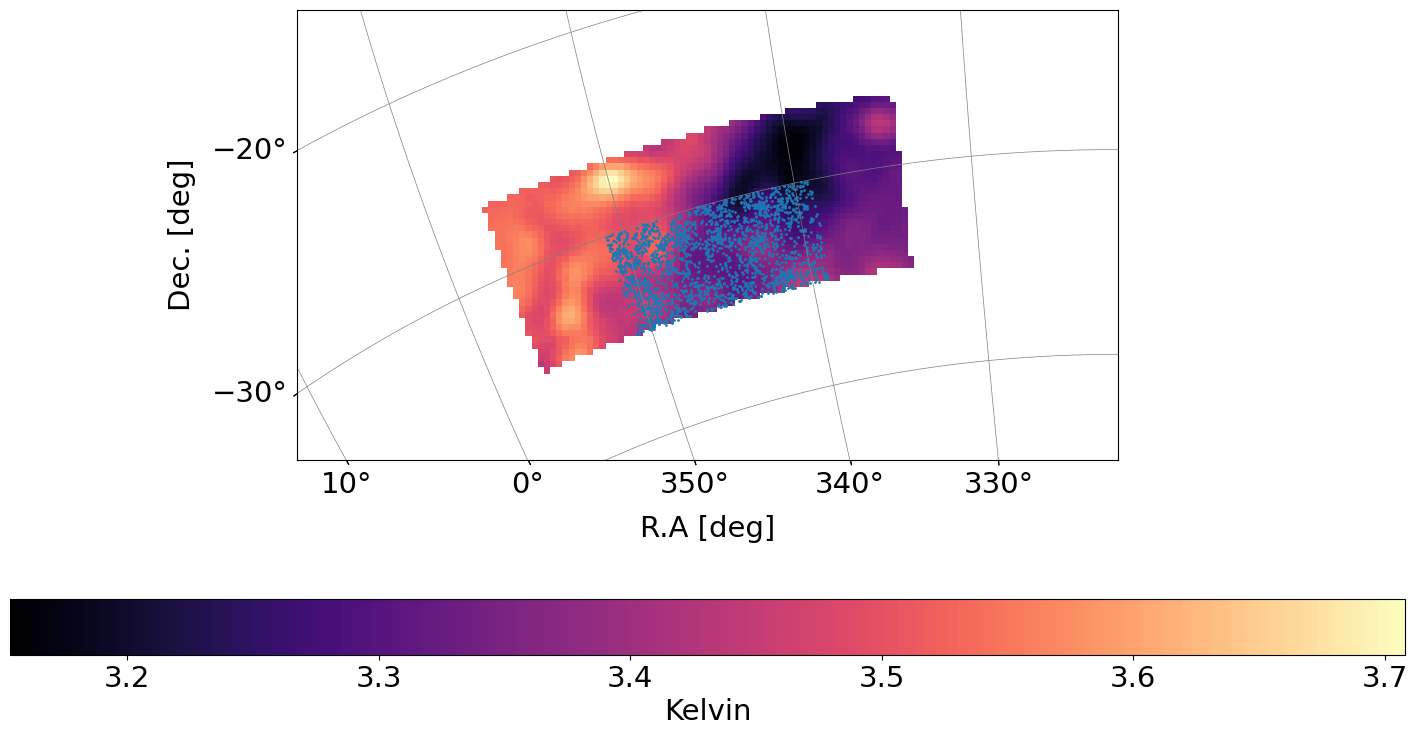

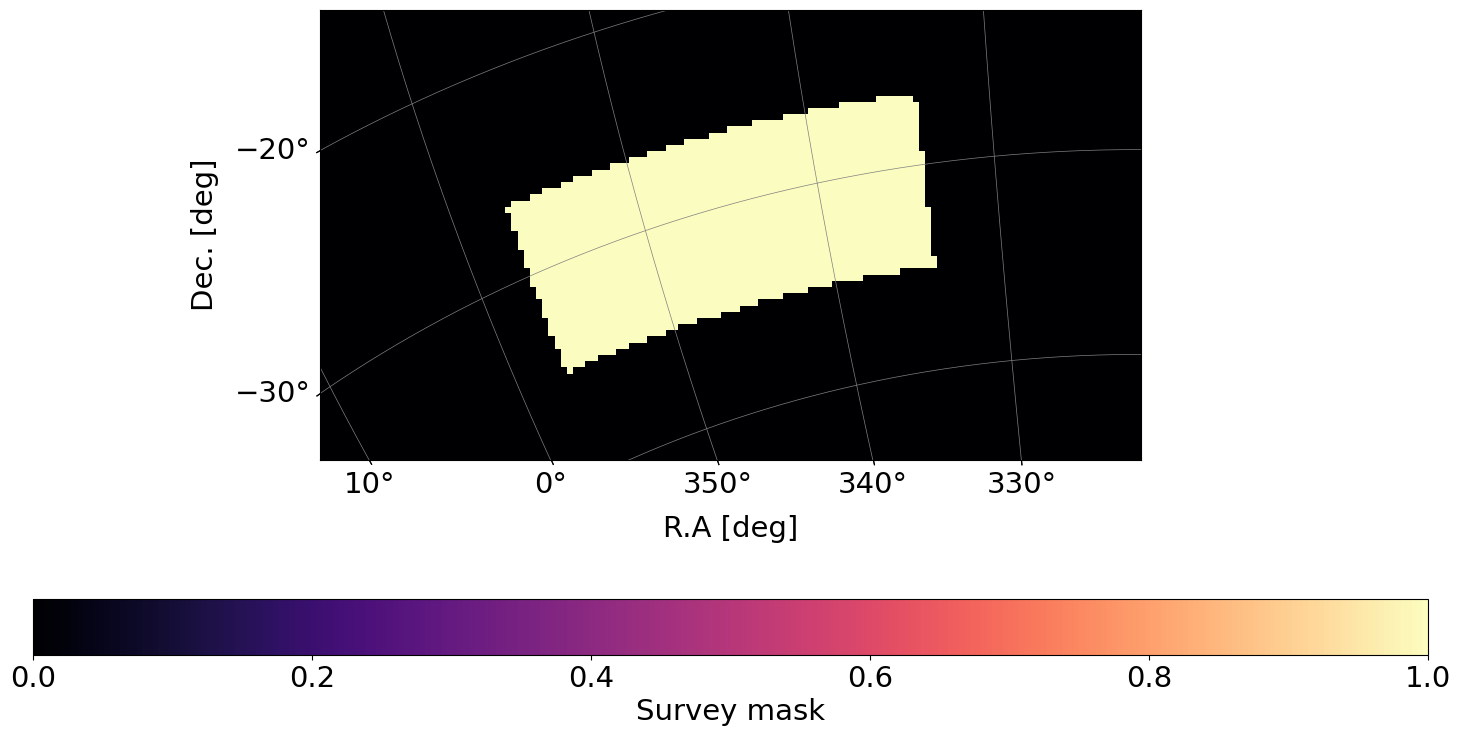

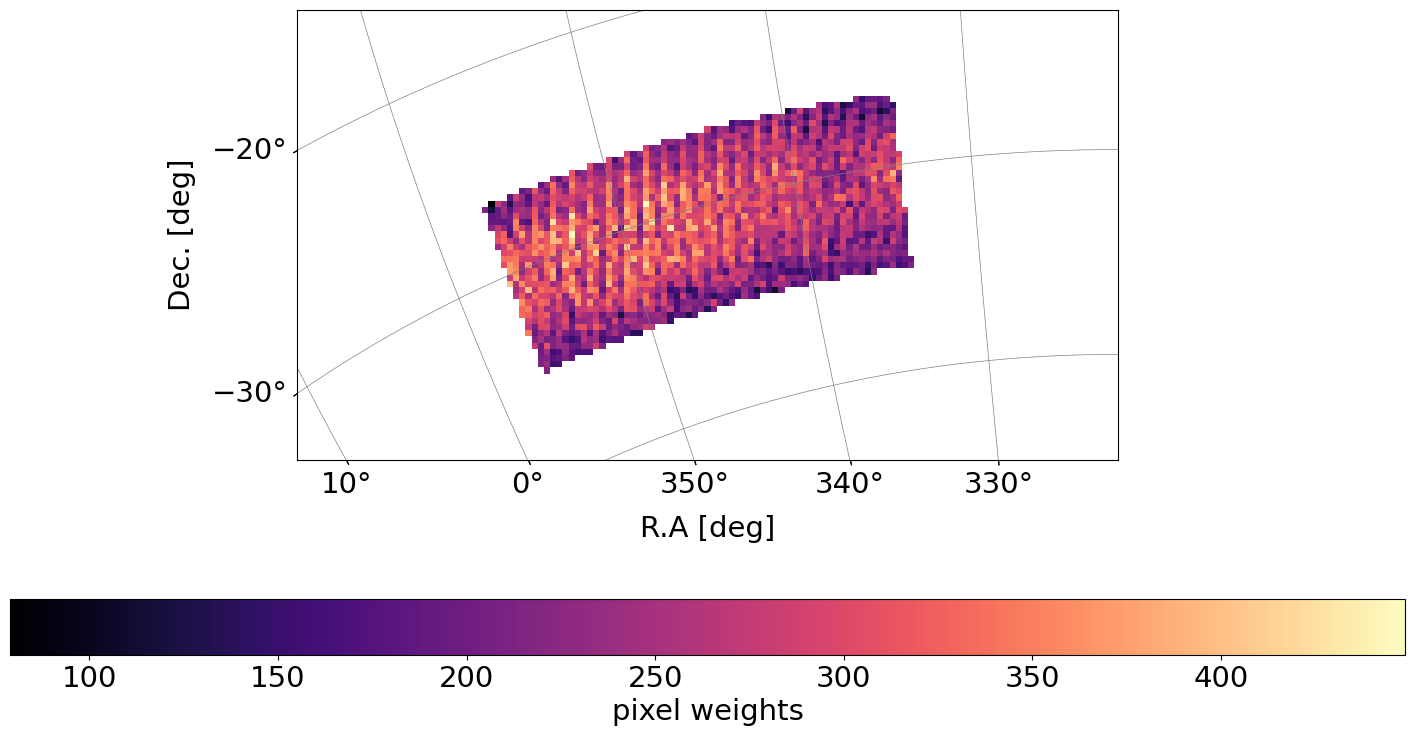

In [5]:
plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
ax = plt.gca()
ax.scatter(
    ps.ra_gal,
    ps.dec_gal,
    transform=ax.get_transform('world'),
    s=1,
    alpha=1,
)
plot_map(ps.W_HI,ps.wproj,have_cbar=True,cbar_label='Survey mask')
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,have_cbar=True,cbar_label='pixel weights')



It is worth noting that, like many other things in `meer21cm`, if you set it up when initialising the instance, the trimming happens automatically. For example:

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


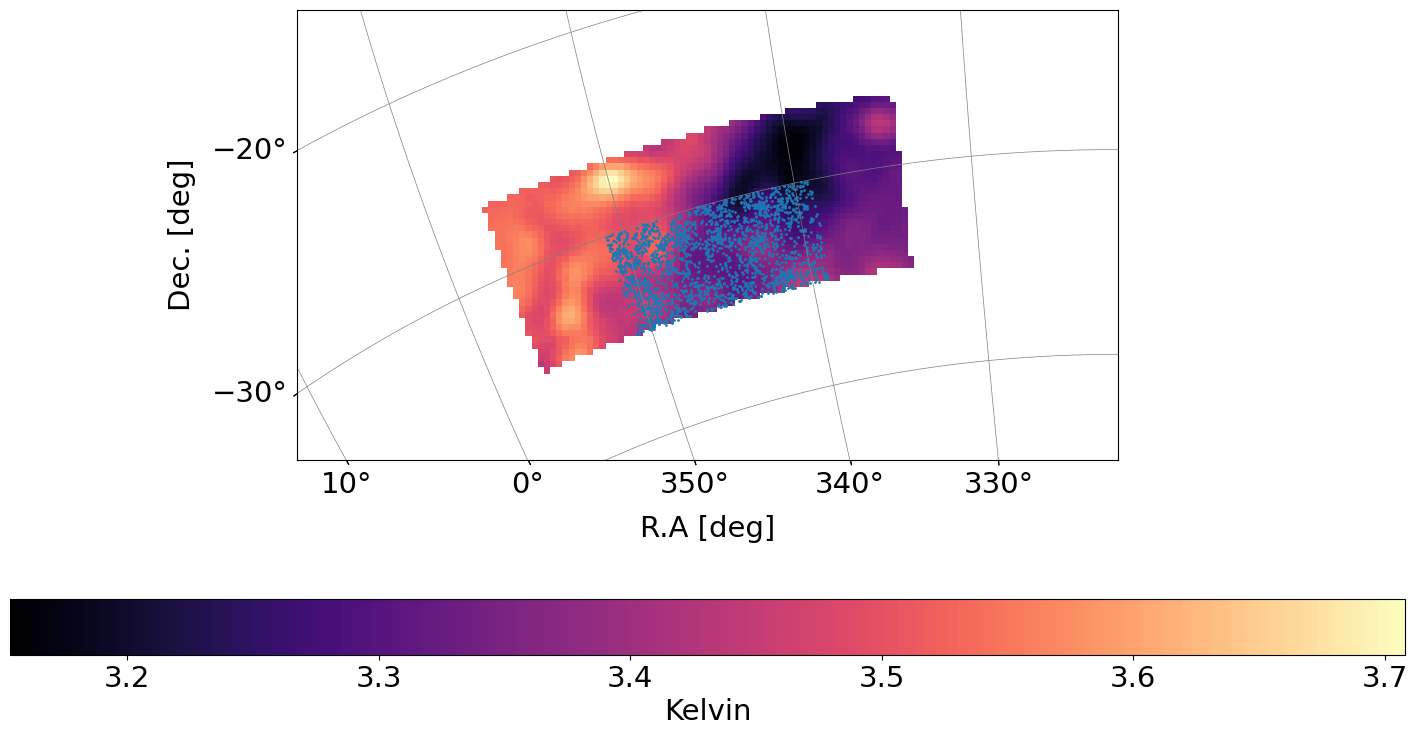

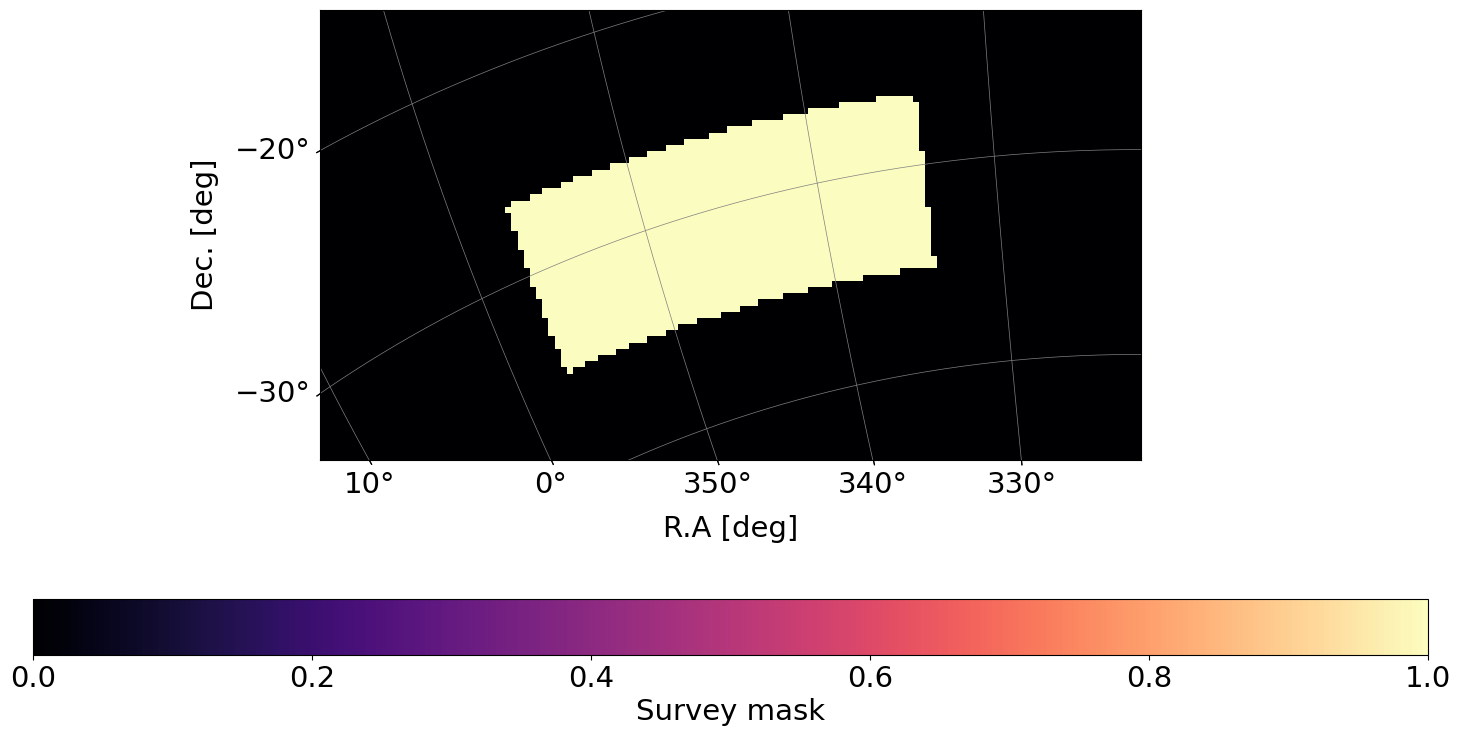

In [6]:
ps = PowerSpectrum(
    map_file=fits_file,
    counts_file=counts_file,
    gal_file=gal_file,
    beam_model='gaussian',
    beam_type='isotropic',
    ra_range = ra_range_GAMA,
    dec_range = dec_range_GAMA,
)
ps.read_gal_cat()
ps.ra_range = ra_range_MK
ps.dec_range = dec_range_MK
ps.read_from_fits()


plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
ax = plt.gca()
ax.scatter(
    ps.ra_gal,
    ps.dec_gal,
    transform=ax.get_transform('world'),
    s=1,
    alpha=1,
)
plot_map(ps.W_HI,ps.wproj,have_cbar=True,cbar_label='Survey mask')



## Step 3: Reconvolution

Note: I am not sure if this step actually helps. My own opinion is that we shouldn't do this. But anyway right now it is part of the pipeline:

In [7]:
D_dish = 13.5 # Dish-diameter [metres]
gamma = 1.4 # resmoothing factor - set = None to have no resmoothing
sigma_ch = dish_beam_sigma(D_dish,ps.nu,)
sigma_max = sigma_ch.max()
# calculate the effective Gaussian beam width for the convolution
reconvolve_sigma = np.sqrt(gamma*sigma_max**2 - sigma_ch**2)
# tell ps to use this beam width:
ps.sigma_beam_ch = reconvolve_sigma
reconv_beam_cube = ps.beam_image.copy()
# reconvolve is a simple function call
ps.convolve_data(reconv_beam_cube)
reconv_data = ps.data.copy()
reconv_weights = ps.w_HI.copy()




Note that beam parameters are later used to calculate the beam attenuation factor in the power spectrum. So remember to update it as it will be used later:


In [8]:
ps.sigma_beam_ch = sigma_ch

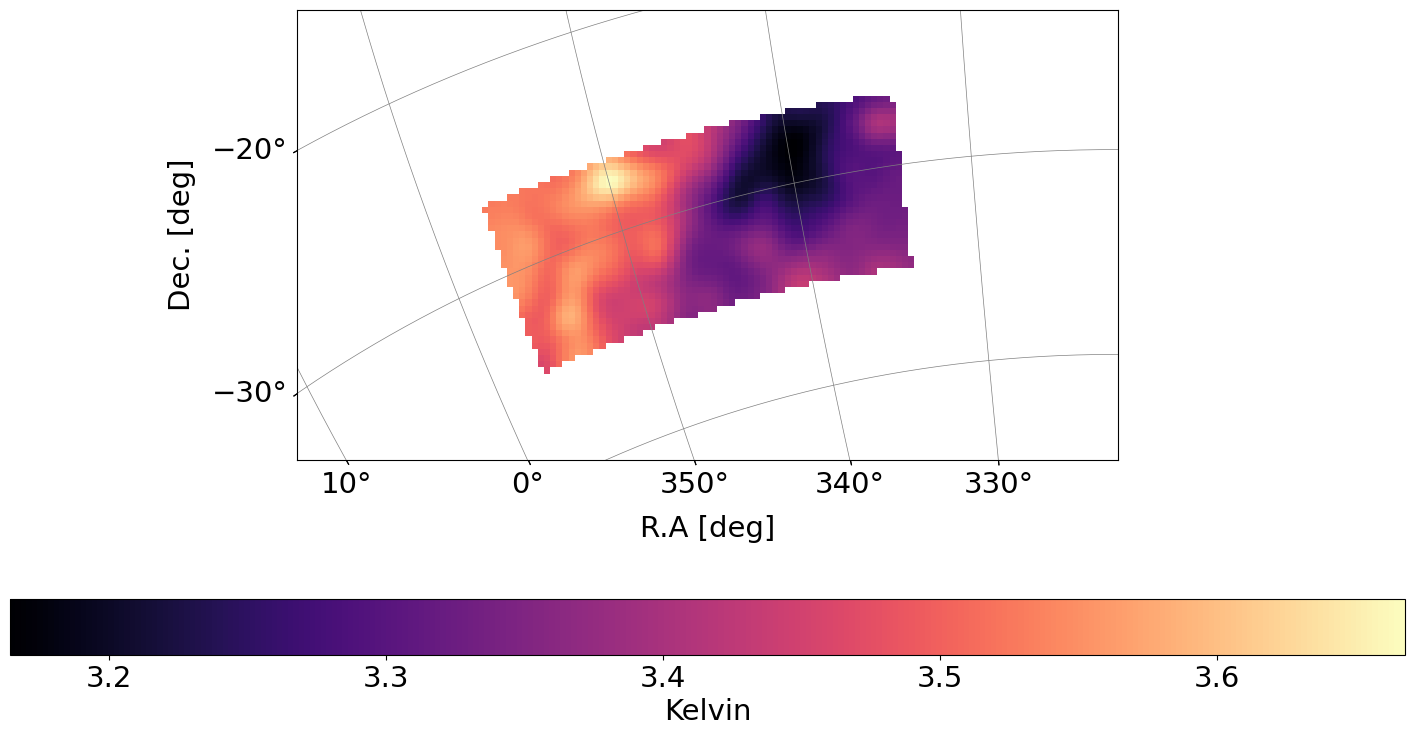

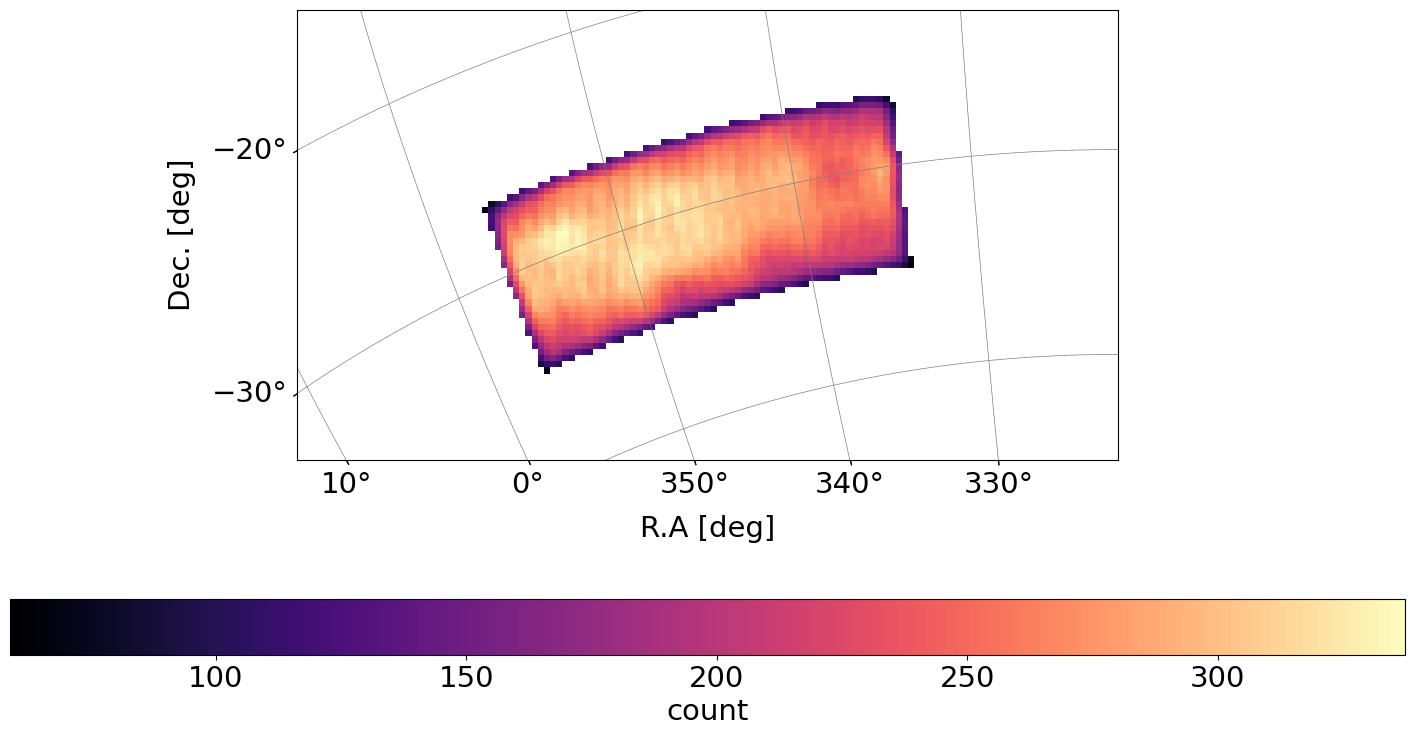

In [9]:
plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,cbar_label='count')

You can examine the pixel spectrum:

Text(0, 0.5, 'Kelvin')

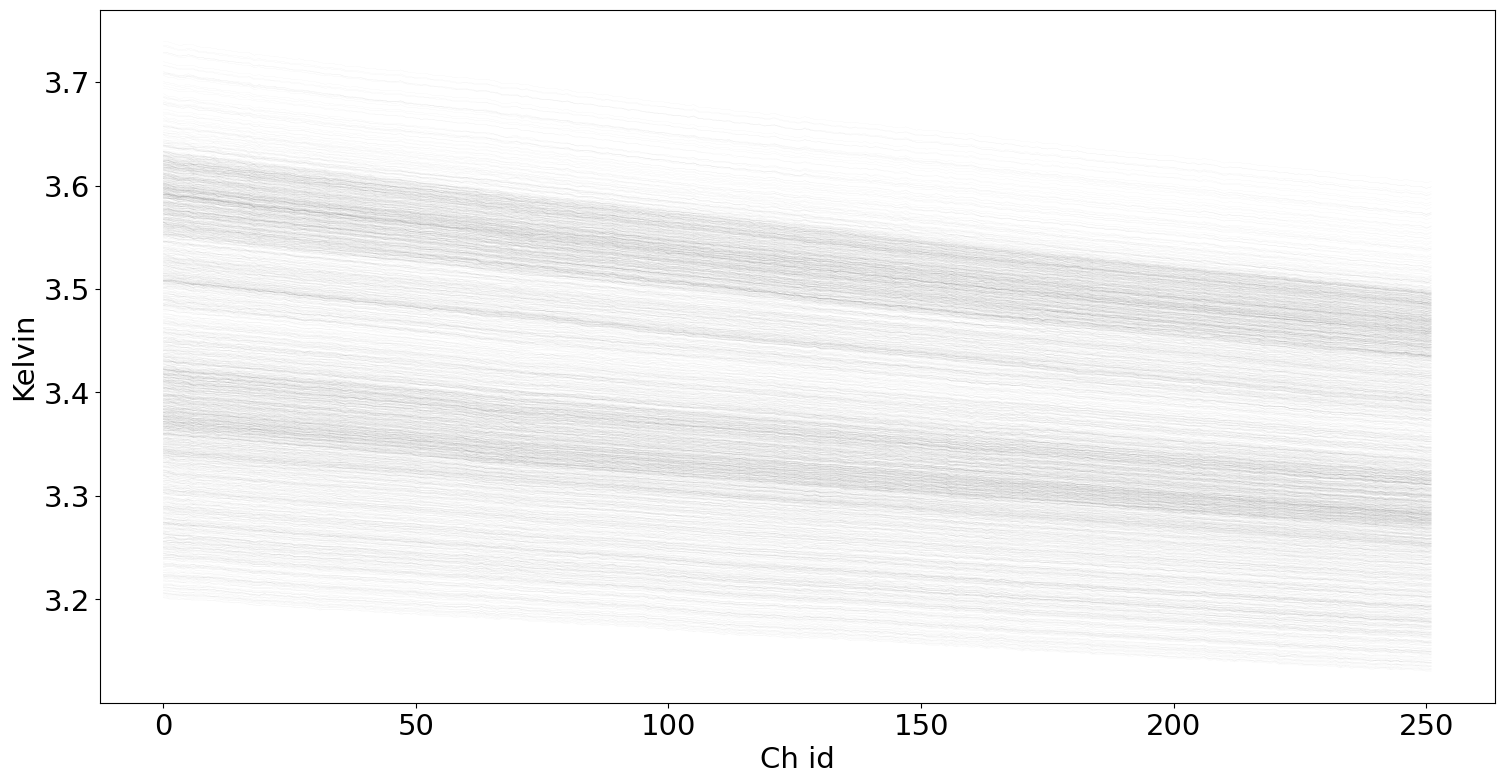

In [10]:
plot_pixels_along_los(ps.data,ps.W_HI)
ax = plt.gca()
ax.set_xlabel('Ch id')
ax.set_ylabel('Kelvin')

## Step 4: PCA cleaning

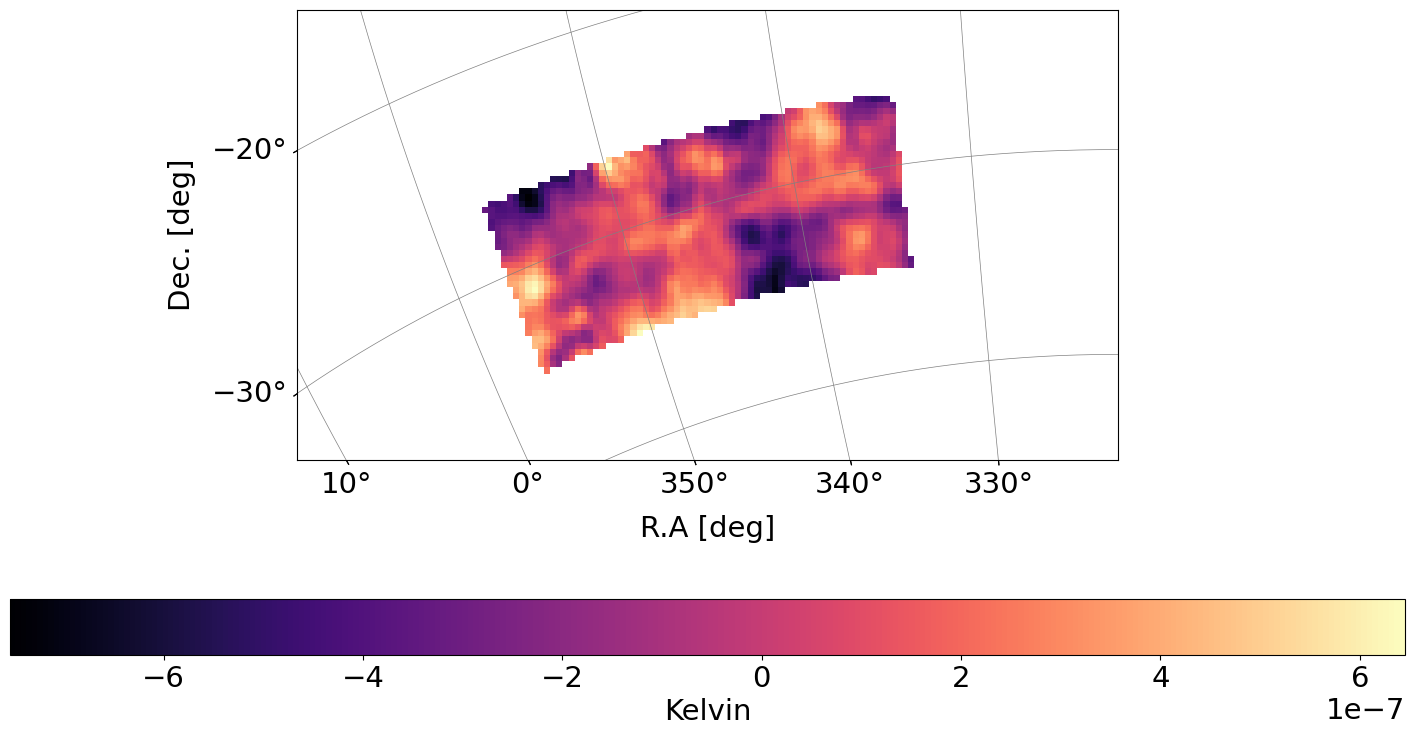

In [11]:
N_fg = 10
MKmap_clean, A_mat = pcaclean(ps.data,N_fg,weights=ps.W_HI,mean_centre=True, return_A=True)
plot_map(MKmap_clean,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')


You can also visualise the eigenmodes of the data:

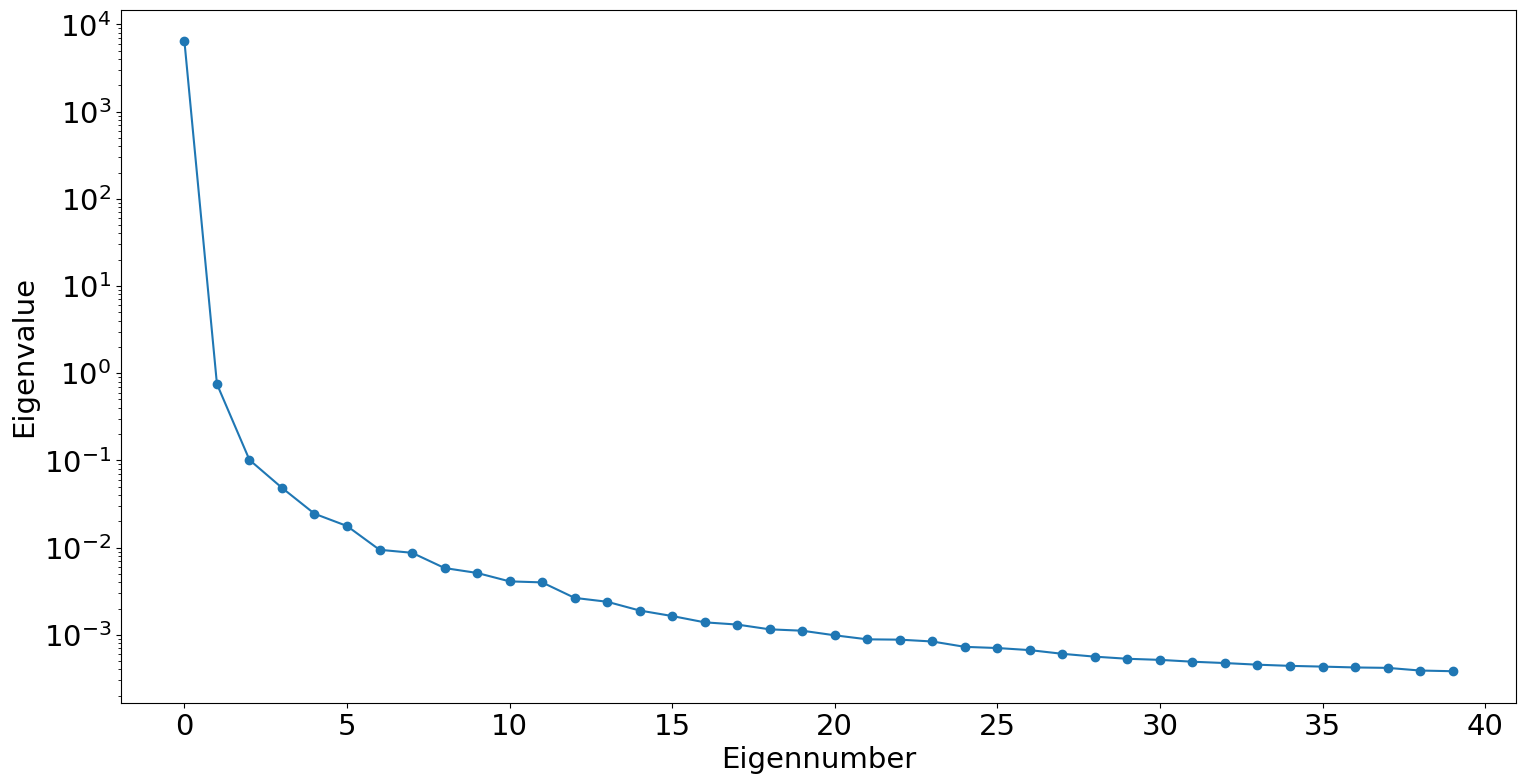

<Figure size 1800x900 with 0 Axes>

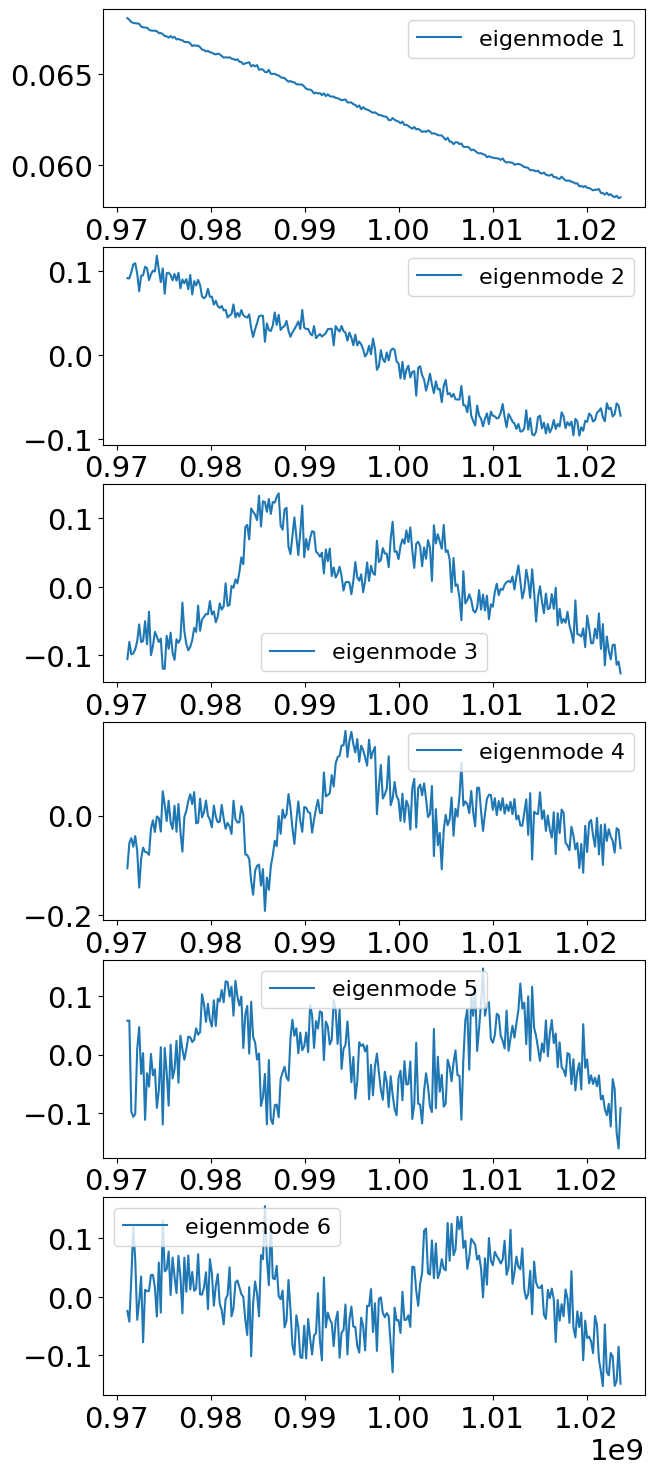

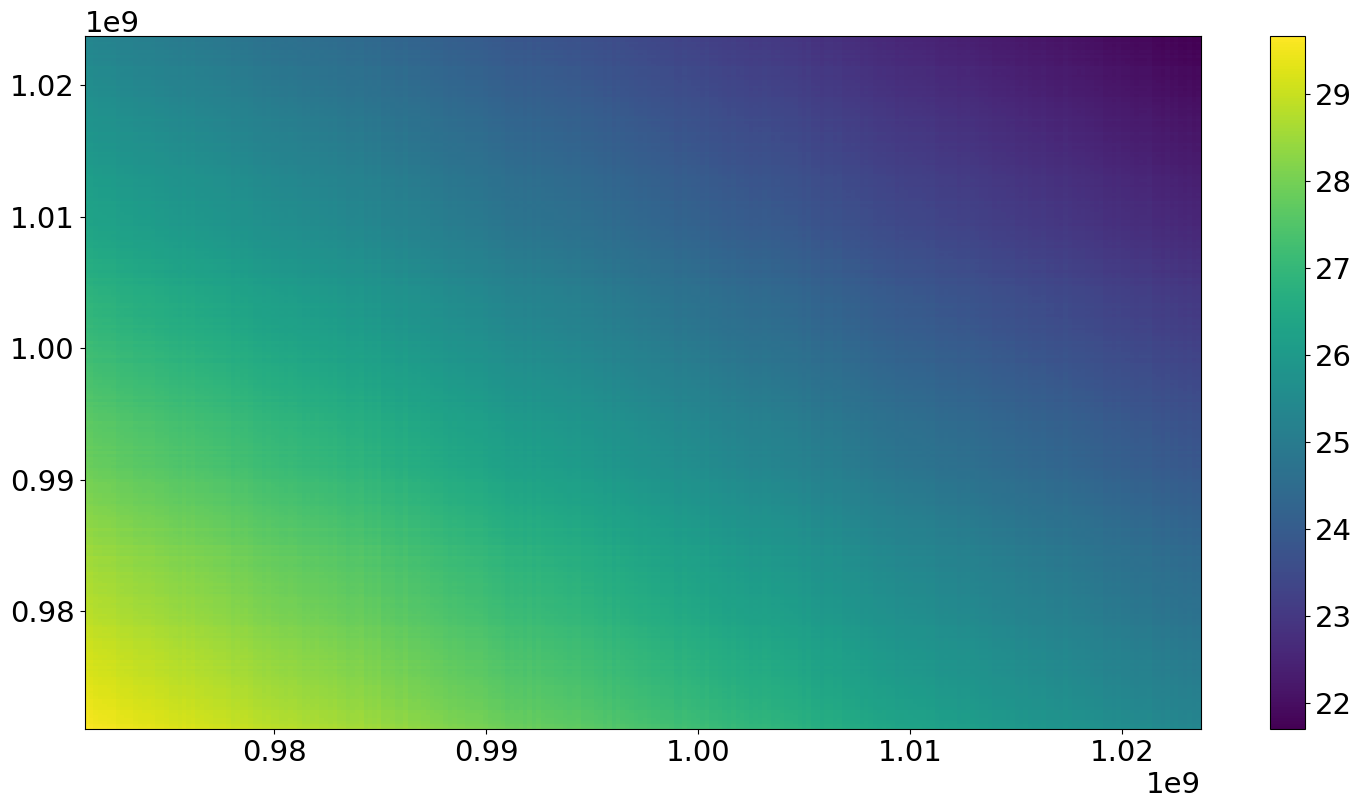

In [12]:
nu_edges = center_to_edges(ps.nu)
cov_map,eignumb,eigenval,V = pcaclean(ps.data,N_fg=1,weights=ps.W_HI,return_analysis=True,mean_centre=True) # weights included in covariance calculation
plot_eigenspectrum(np.array([eigenval]))
plt.figure()
Num = 6
chart = 100*Num + 11
plt.figure(figsize=(7,3*Num))
for i in range(Num):
    plt.subplot(chart + i)
    plt.plot(ps.nu,V[:,i],label='eigenmode %s'%(i+1))
    #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
    plt.legend(fontsize=16)
plt.figure()
plt.pcolormesh(nu_edges,nu_edges,cov_map)
plt.colorbar()
plt.show()

Now we can plug the cleaned map into `mock` for PS calculation:

In [13]:
ps.data = MKmap_clean

Note here that, again this is very flexible due to modulised coding. Instead of PCA cleaning, you can choose any of your favourite algorithm, clean it, and then plug it back to `mock`.

For cross-correlation, we only care about the GAMA region. So for simplicity here we can trim the map again to just the GAMA region:

In [14]:
ps.ra_range = ra_range_GAMA
ps.dec_range = dec_range_GAMA
ps.trim_map_to_range()

## Step 5: Gridding

Now we need to grid the sky map back to some rectangular grids.

In [15]:
# specify some scaling factor
ps.downres_factor_transverse = 1.2
ps.downres_factor_radial = 1.5
ps.box_buffkick = 10
ps.grid_scheme = 'nnb'

Some explanation of the parameters.

When we grid, we first need to choose our desired resolution.

The map itself has an effective resolution:

In [16]:
ps.pix_resol_in_mpc,ps.los_resol_in_mpc

(8.832036679403524, 1.045337116042852)

Normally, you want the gridding to be at a lower resolution than the map resolution.

So by setting `ps.downres_factor_transverse` and `ps.downres_factor_radial`, you are creating a box so that the resolution is scaled down by (approximately) these two factors:

In [17]:
ps.get_enclosing_box() # get the minimum enclosing box for the survey lightcone
ps.box_resol / np.array([ps.pix_resol_in_mpc,ps.pix_resol_in_mpc,ps.los_resol_in_mpc])

array([1.14128532, 1.22185631, 1.49504158])

Also, when we find the minimum enclosing box, sometimes we want to create a buffer so that there is some empty space between the rectangular box edges and the survey lightcone. This buffer is controlled by `ps.box_buffkick` (in unit of Mpc)

Finally, assigning the map pixels to the grids requires a scheme. `meer21cm` supports `nnb` (nearest neighbour), `cic` (cloud in cloud), `tsc` (triangular shape cloud) and `pcs` (piecewise cubic spline). See [Cunnington & Wolz](https://arxiv.org/pdf/2312.07289) for more details.

One more thing is the inner-pixel Monte-Carlo sampling, which is not currently implemented and still being tested.

Given the resolution and the box size, you can then grid the map data to the grids:

In [18]:
hi_map_rg,hi_weights_rg,pixel_counts_hi_rg =  ps.grid_data_to_field()

/Users/zhaotingchen/Desktop/work/meer21cm/src/meer21cm/grid.py:412: RuntimeWarning: invalid value encountered in divide
  mesh_mass = np.where(mesh_weights > 0, mesh_mass / mesh_weights, 0)


Here, `hi_map_rg` is the gridded HI temp field. `hi_weights_rg` is the weights for each grid from the map pixel weights (counts), and `pixel_counts_hi_rg` is the number of pixels that fall into each grid.

You can visualise the lightcone and weights:

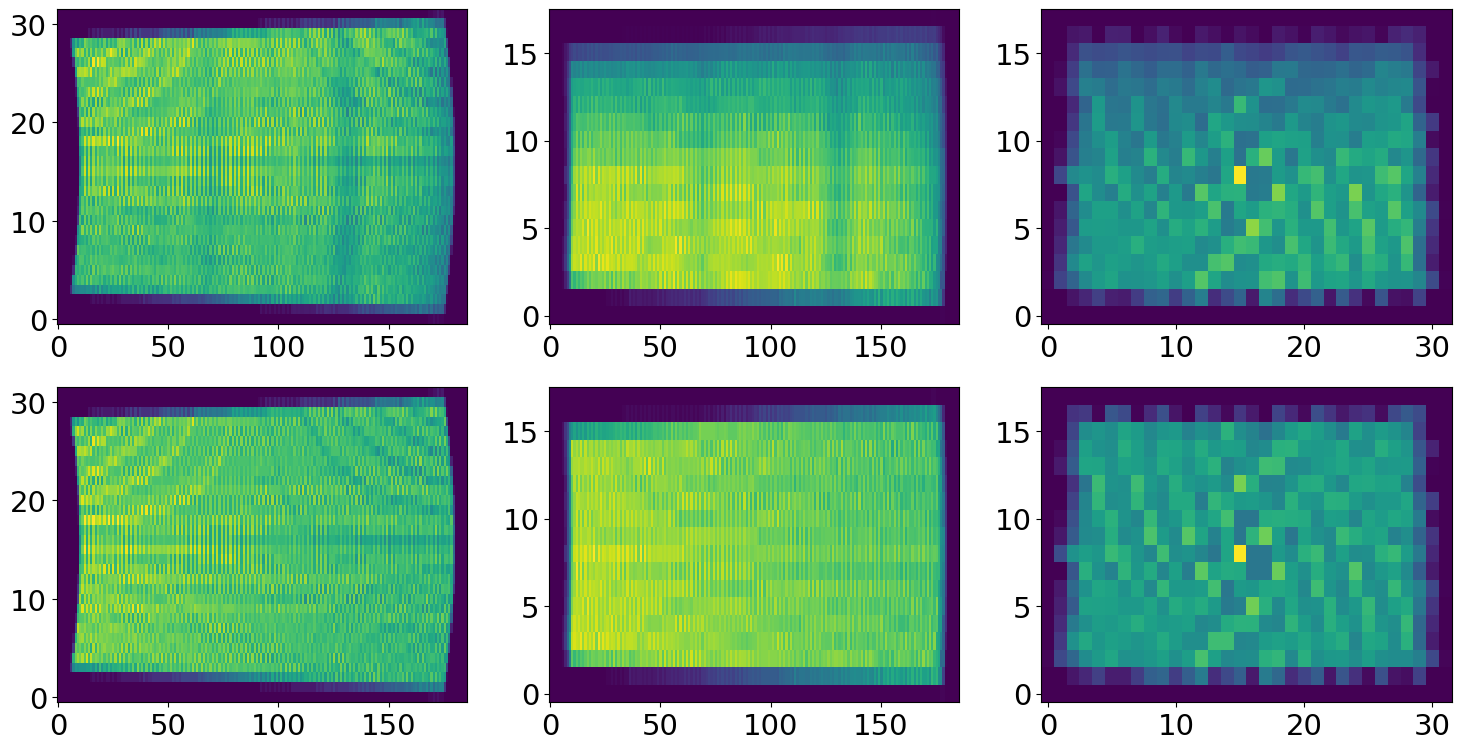

In [19]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    axes[0,i].imshow(
        hi_weights_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    axes[1,i].imshow(
        pixel_counts_hi_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

Note that weights and pixel counts are not the same since pixels have different counts.

Similarly we can grid the galaxy field:

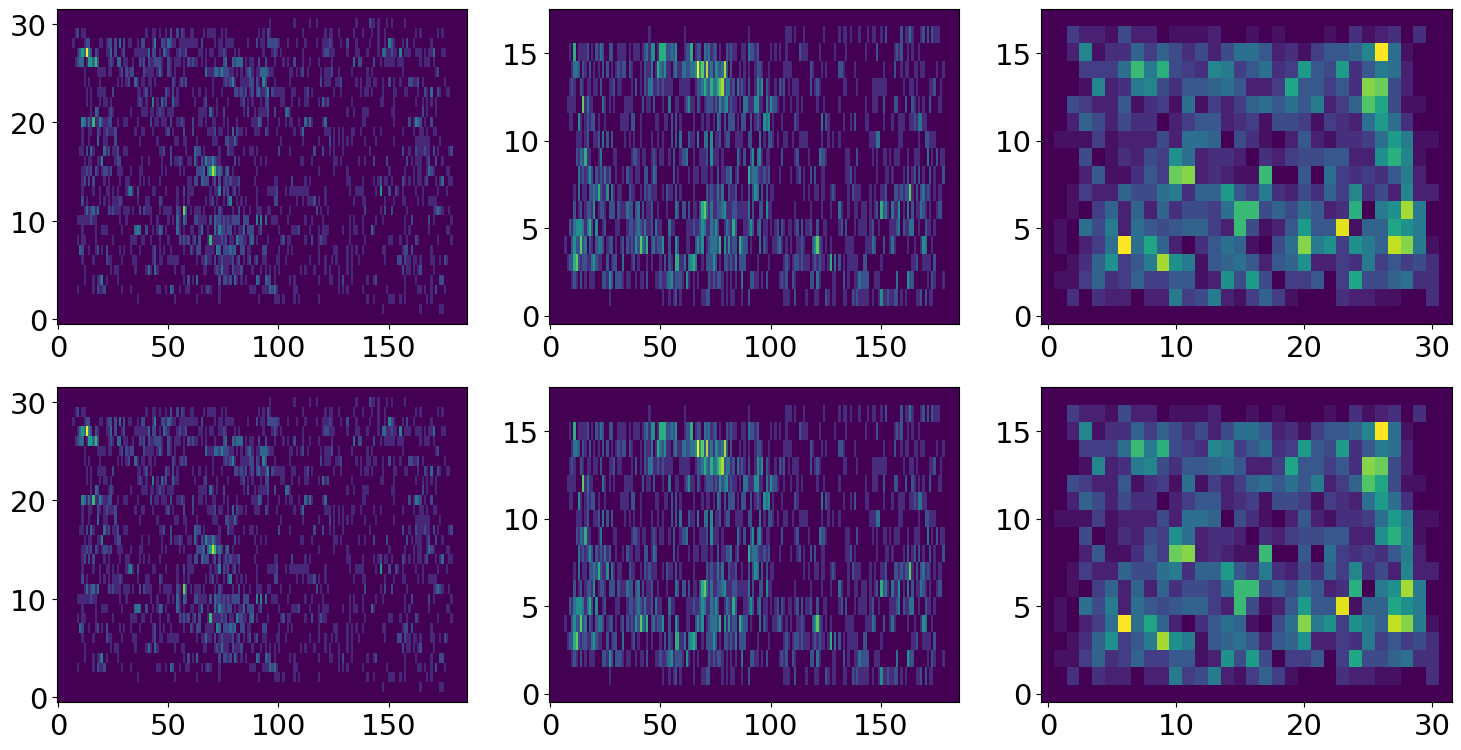

In [20]:
gal_map_rg,gal_weights_rg,pixel_counts_gal_rg =  ps.grid_gal_to_field()
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    axes[0,i].imshow(
        gal_weights_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    axes[1,i].imshow(
        pixel_counts_gal_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

Note that **for galaxy, this is not the actual weights**. This is just if the grids have galaxies fall into them and how many.

For GAMA galaxy, we assume uniform survey mask, so the weights should just be where the grids are actually in the survey lightcone, `pixel_counts_hi_rg>0`

Now, we can plug in the gridded fields and weights to estimate the power spectra (see Tutorial I).

In [ ]:
ps.field_1 = hi_map_rg
ps.weights_1 = hi_weights_rg
ps.field_2 = gal_map_rg
ps.weights_2 = (pixel_counts_hi_rg>0).astype('float')
ps.mean_center_1 = False # the field is already mean centered
ps.mean_center_2 = True # galaxy count is not
ps.unitless_1 = False # HI field is in temperature unit, does not need to 1/\bar{\pho}
ps.unitless_2 = True # galaxy count to overdensity needs 1/\bar{n}
ps.sampling_resol = np.array([
        ps.pix_resol_in_mpc,
        ps.pix_resol_in_mpc,
        ps.los_resol_in_mpc,
])
ps.compensate = True
ps.include_sky_sampling = [True, False]

A small technique detail: You can see from the HI weights that, the sampling of the sky in the regular grids has these small scale structure due to projecting curved sky to rectangular box. This is not desired because it creates structure in the power spectrum window function. Instead, you may want to taper the field.

By default, `meer21cm` uses a Blackman-Harris window (note that fiducial `meerpower` uses turkey window instead):

In [22]:
print(ps.taper_func)

<function blackmanharris at 0x13ff7ab90>


If you do not want taper, you can always set `ps.taper_func = np.ones`.

If you want, you can apply the taper to the weights:

In [23]:
ps.apply_taper_to_field(1, axis=[0,1,2]) # apply taper to field 1(HI), taper in all directions

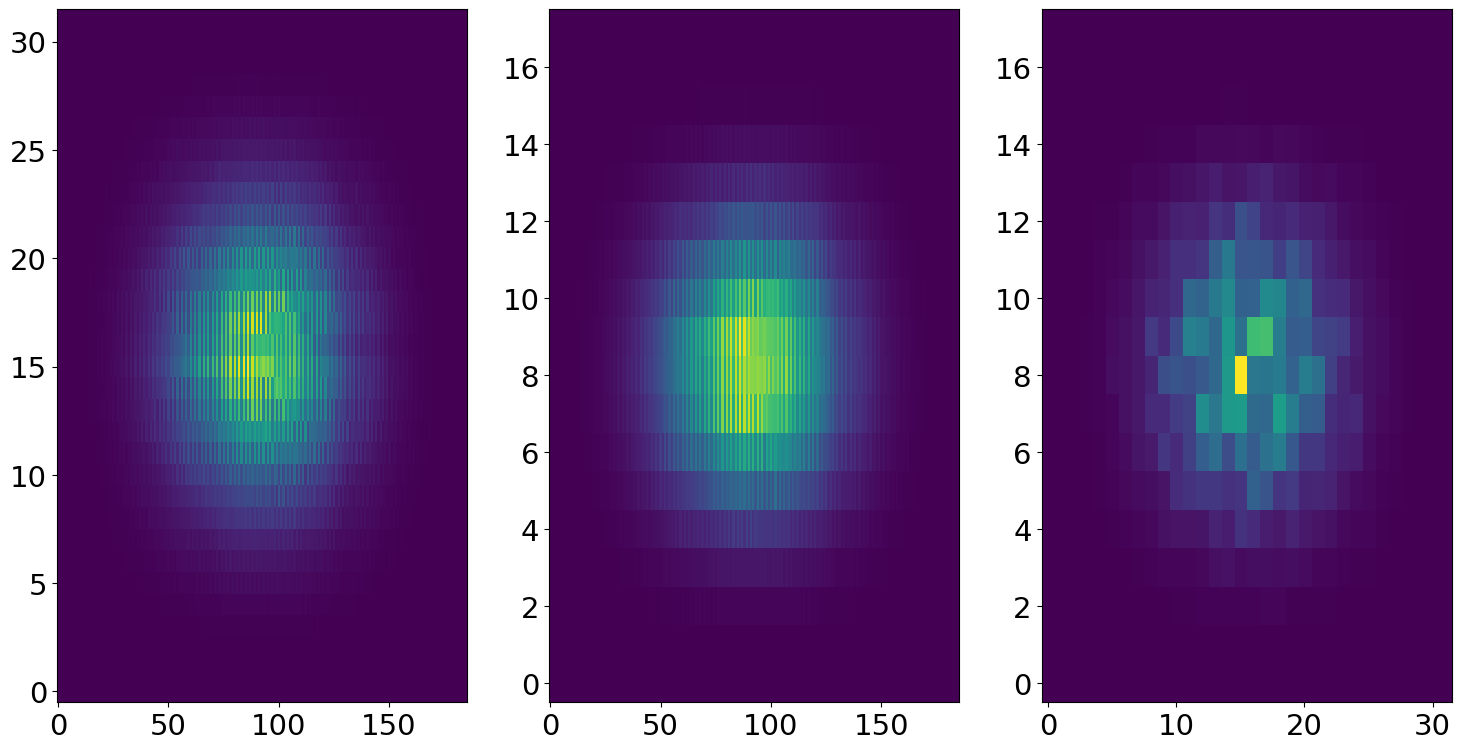

In [24]:
### Gridding sanity-check
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(
        ps.weights_1.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

## Step 6: Power Spectrum estimation

Everything is just automatic. It is already in `ps` waiting to be calculated:

In [25]:
ps.auto_power_3d_1.shape,ps.auto_power_3d_2.shape,ps.cross_power_3d.shape

((18, 32, 186), (18, 32, 186), (18, 32, 186))

Again (see Tutorial I), the accociated k-mode is already stored.

In [26]:
ps.k_mode.shape,ps.k_mode[ps.k_mode!=0].min(),ps.k_mode.max()

((18, 32, 186), 0.01819486717652749, 2.0549475953987897)

Define the k-bins for 1D power spectrum:

In [104]:
nkbin = 16
# in h/Mpc
kmin,kmax = 0.07,0.3
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
# in Mpc-1
kbins *= ps.h
# in h/Mpc
kcuts = [0.052,0.031,0.175,np.inf] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)
# in Mpc-1
kcuts = np.array(kcuts) * ps.h

ps.k1dbins = kbins


In [105]:
pdata_1d_gg,keff,nmodes = ps.get_1d_power(ps.auto_power_3d_2)
pdata_1d_cross,keff_c,nmodes_c = ps.get_1d_power(ps.cross_power_3d)
pdata_1d_hi,keff_hi,nmodes_hi = ps.get_1d_power(ps.auto_power_3d_1)
# shot noise for galaxy auto-power
psn = ps.survey_volume/ps.ra_gal.size

Text(0.5, 1.0, 'Galaxy auto-power spectrum')

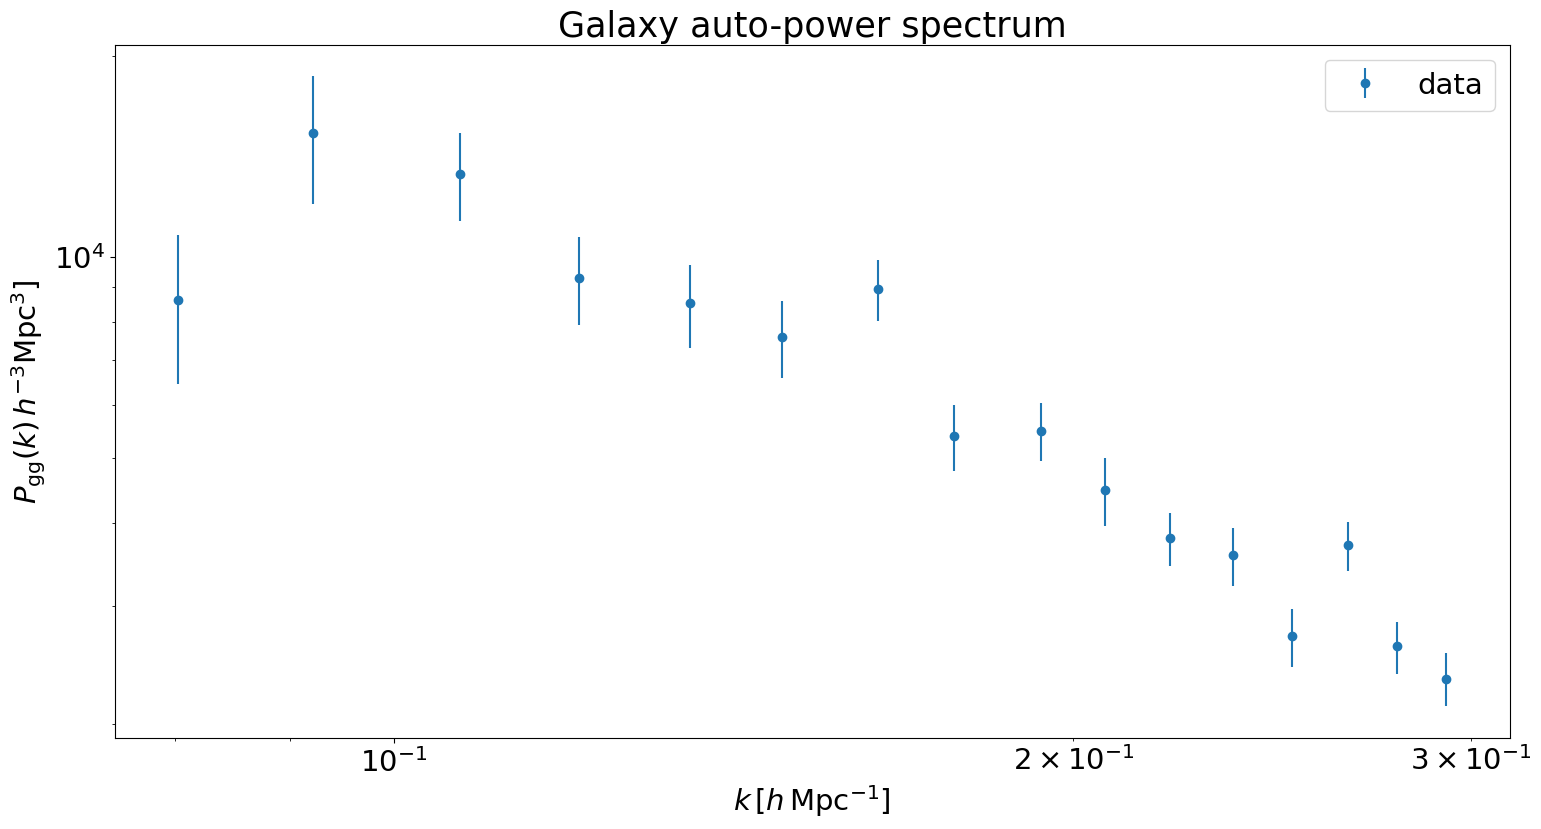

In [106]:
# a naive error bar 
perror_1d_gg = (pdata_1d_gg)/np.sqrt(nmodes)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff/ps.h,(pdata_1d_gg-psn)*ps.h**3,
             yerr=perror_1d_gg*ps.h**3,
             ls='none',
             marker='o',
             label='data')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm gg}(k)\,h^{-3}{\rm Mpc}^3]$')
plt.title('Galaxy auto-power spectrum')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

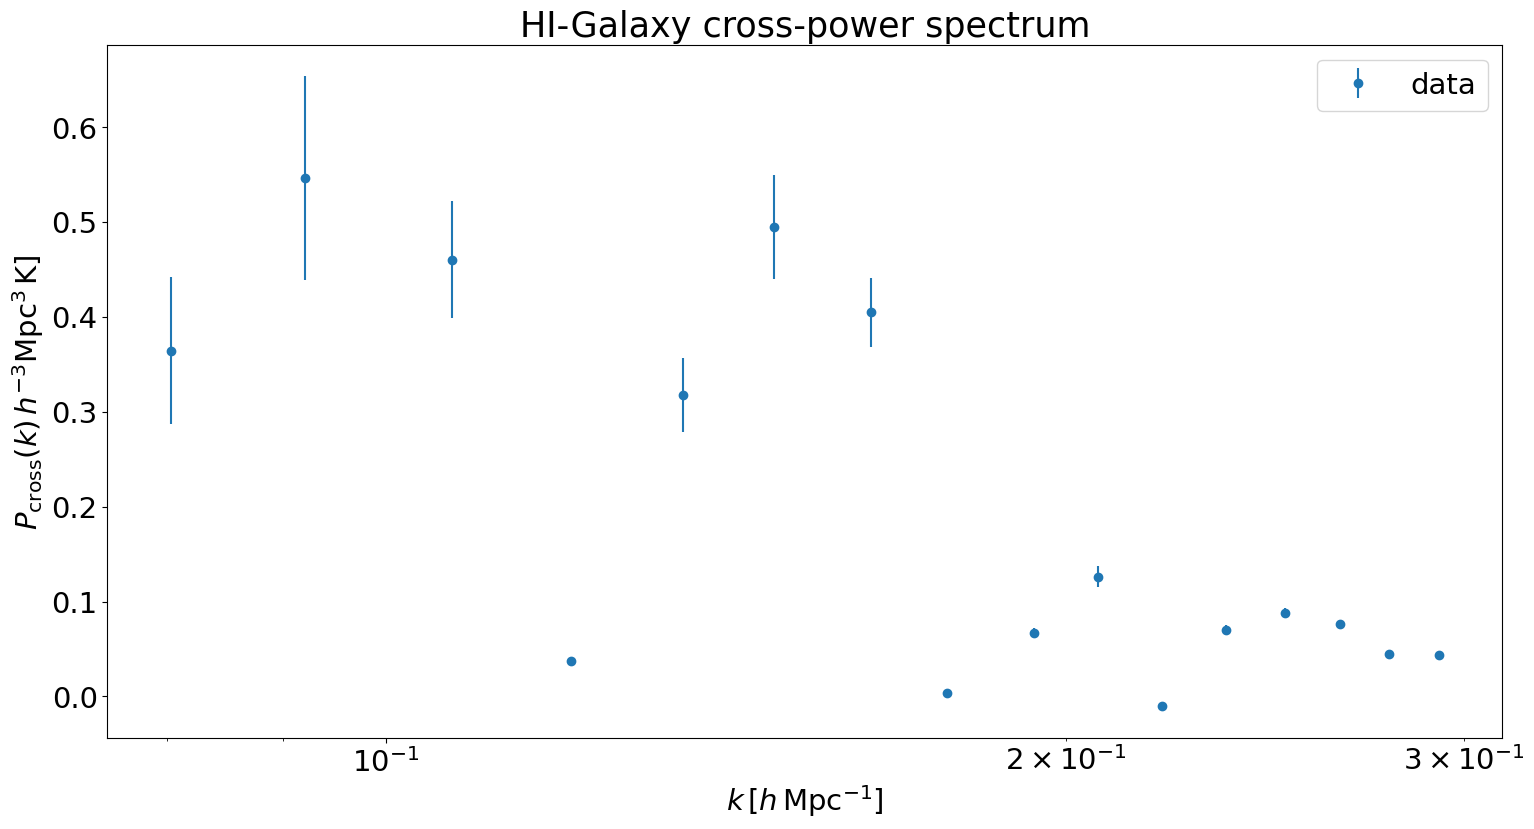

In [107]:
# a naive error bar 
perror_1d_c = np.abs(pdata_1d_cross)/np.sqrt(nmodes_c)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff_c/ps.h,(pdata_1d_cross)*ps.h**3,
             yerr=perror_1d_c*ps.h**3,
             ls='none',
             marker='o',
             label='data')

plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

Note that this is not signal loss corrected.

Text(0.5, 1.0, 'HI auto-power spectrum')

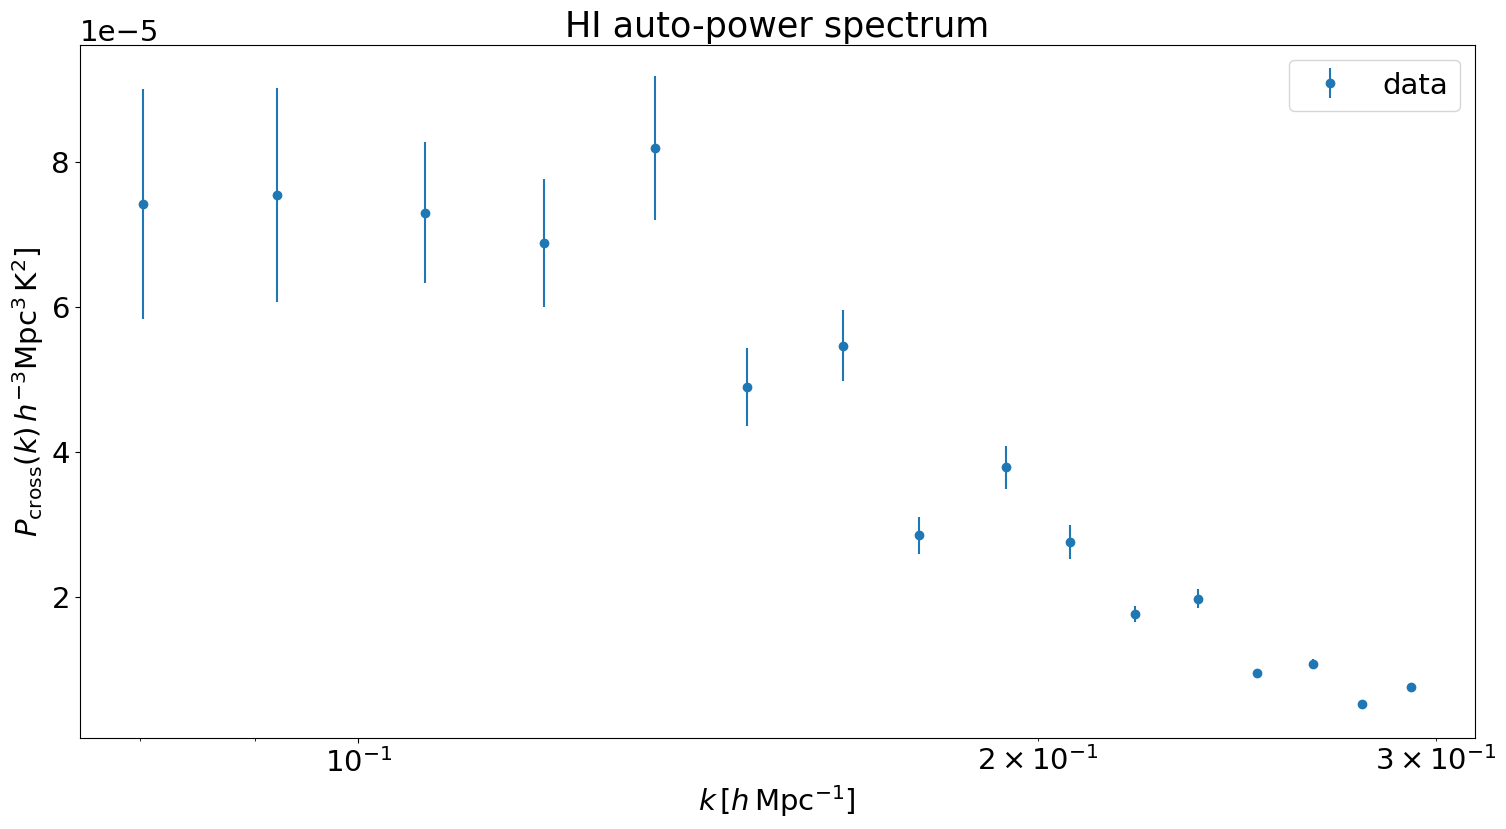

In [108]:
# a naive error bar 
perror_1d_hi = np.abs(pdata_1d_hi)/np.sqrt(nmodes_hi)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff_hi/ps.h,(pdata_1d_hi)*ps.h**3,
             yerr=perror_1d_hi*ps.h**3,
             ls='none',
             marker='o',
             label='data')

plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,K^2}]$')
plt.title('HI auto-power spectrum')

## Step 7: Signal loss correction

For mock injection and signal loss correction, it is important to make sure the mock goes through the same processes as the data. This is easy in `meer21cm`, because as long as your `mock` has the exact same input as `ps`, it is guaranteed automatically.

The routine for simulating the mock observations can be found in `quick_start`.

We need to first specify a model:


In [33]:
bias_HI = 1.5
bias_gal = 1.9
omega_HI = 0.85e-3 / bias_HI

In [34]:
num_g_GAMA = ps.ra_gal.size
mock = MockSimulation(
    ra_range = ra_range_MK,
    dec_range = dec_range_MK,
    tracer_bias_1 = bias_HI,
    tracer_bias_2 = bias_gal,
    downres_factor_radial=0.5, # highres in radial direction
    downres_factor_transverse=0.5, # highres in transverse direction
    box_buffkick=10,
    mean_amp_1='average_hi_temp',
    omegahi = omega_HI,
    sigma_beam_ch = sigma_ch,
    counts_file = counts_file,
    fits_file = fits_file,
)
# N_g_MK = N_g_GAMA * V_MK/V_GAMA
num_g_MK = int(num_g_GAMA * mock.survey_volume / ps.survey_volume)
mock.num_discrete_source = num_g_MK

/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)


In [35]:
# generate HI temp map
mock.data = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
# convolve it with the beam
mock.convolve_data(mock.beam_image)
# then reconvolve
mock.convolve_data(reconv_beam_cube)
# generate mock galaxy catalogue
mock.propagate_mock_tracer_to_gal_cat()

Note: redshifts have been re-sorted (earliest first)


/Users/zhaotingchen/Desktop/work/meer21cm/src/meer21cm/mock.py:381: UserWarning: Not enough tracers inside the ra, dec, z range. Try increasing target_relative_to_num_g.
  warnings.warn(


let's have a sanity check of the simulation:

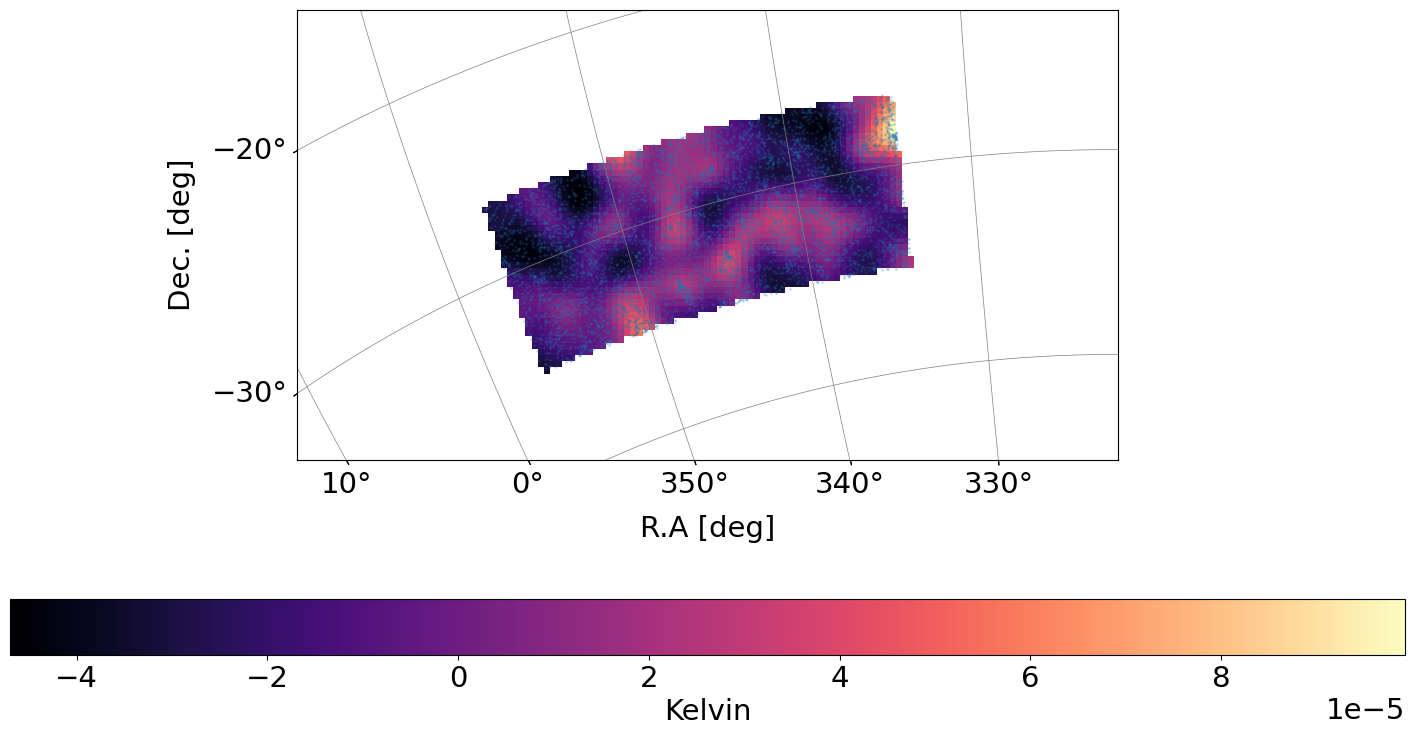

In [36]:
plot_map(mock.data,mock.wproj,W=mock.W_HI,cbar_label='Kelvin')
ax = plt.gca()
ax.scatter(
    mock.ra_gal,
    mock.dec_gal,
    transform=ax.get_transform('world'),
    s=1,
    alpha=0.2,
)

Now we can inject this to the map data and repeat the procedure:

In [ ]:
hi_mock_map = mock.data.copy()
# combine the data
mock.data = hi_mock_map + reconv_data
mock.w_HI = reconv_weights
# perform PCA
clean_map, A_mat_mock = pcaclean(mock.data,N_fg,weights=mock.W_HI,mean_centre=True, return_A=True)


In [47]:
R_mat_mock = np.eye(mock.nu.size) - A_mat_mock @ A_mat_mock.T

You can then retrieve the cleaned mock HI signal:

In [49]:
hi_mock_mean_centered = (
    hi_mock_map - ((hi_mock_map * mock.W_HI).sum(-1) / mock.W_HI.sum(-1))[:,:,None]
)
hi_mock_cleaned = np.einsum('ij,abj->abi',R_mat_mock,hi_mock_mean_centered)

/var/folders/g4/7xh65ljx6l17g9wztg7t6c2w0000gn/T/ipykernel_44389/520935508.py:2: RuntimeWarning: invalid value encountered in divide
  hi_mock_map - ((hi_mock_map * mock.W_HI).sum(-1) / mock.W_HI.sum(-1))[:,:,None]


Now, we can recreate the GAMA cross with mock and calculate a transfer function:

In [109]:
mock.data = hi_mock_cleaned
mock.ra_range = ra_range_GAMA
mock.dec_range = dec_range_GAMA
mock.trim_map_to_range()
mock.trim_gal_to_range()

array([ True,  True,  True, ...,  True,  True,  True])

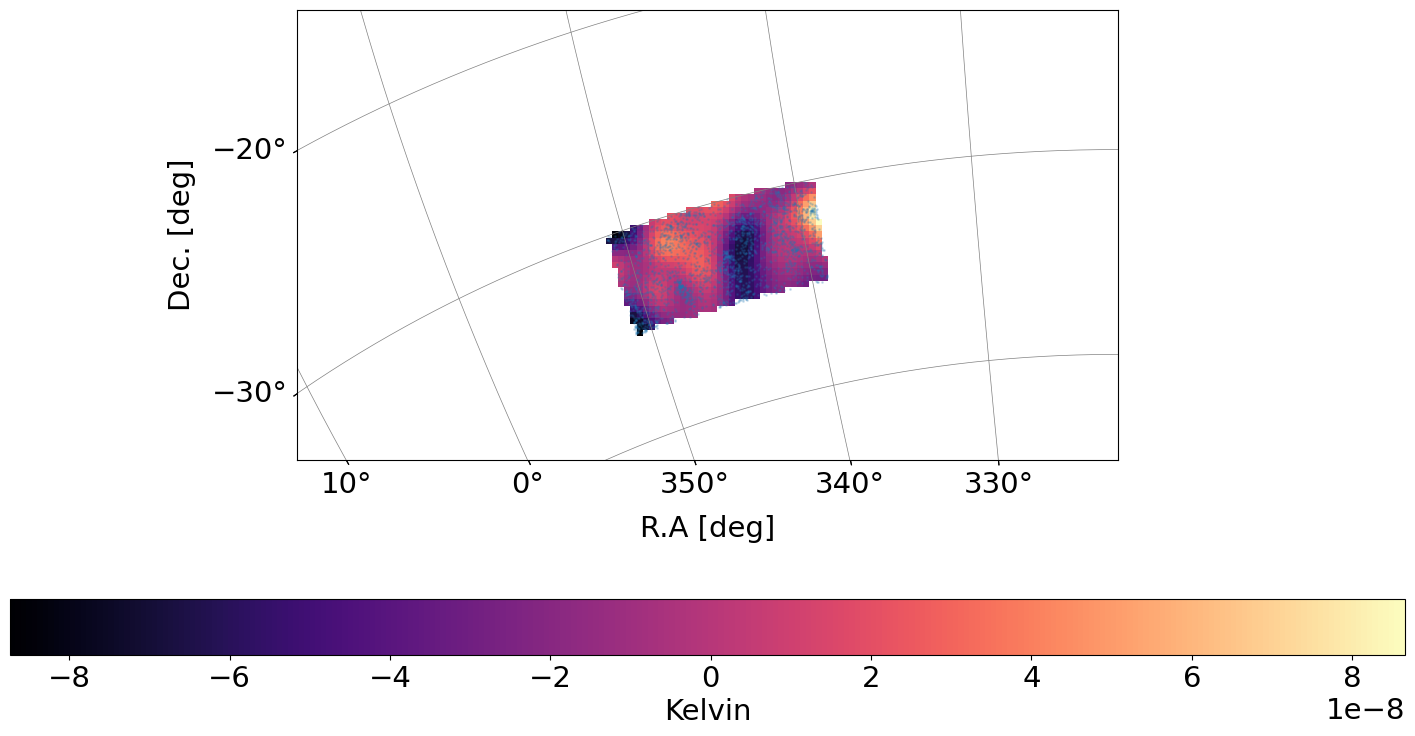

In [110]:
plot_map(mock.data,mock.wproj,W=mock.W_HI,cbar_label='Kelvin')
ax = plt.gca()
ax.scatter(
    mock.ra_gal,
    mock.dec_gal,
    transform=ax.get_transform('world'),
    s=1,
    alpha=0.2,
)


In [111]:
# specify some scaling factor
mock.downres_factor_transverse = ps.downres_factor_transverse
mock.downres_factor_radial = ps.downres_factor_radial
mock.box_buffkick = ps.box_buffkick
mock.grid_scheme = ps.grid_scheme
mock.sampling_resol = ps.sampling_resol
mock.compensate = ps.compensate
mock.include_sky_sampling = ps.include_sky_sampling
mock.taper_func = np.ones
mock.grid_data_to_field()
mock.grid_gal_to_field()
mock.taper_func = ps.taper_func
mock.apply_taper_to_field(1, axis=[0,1,2])



/Users/zhaotingchen/Desktop/work/meer21cm/src/meer21cm/grid.py:412: RuntimeWarning: invalid value encountered in divide
  mesh_mass = np.where(mesh_weights > 0, mesh_mass / mesh_weights, 0)


Note that, in fact `mock.grid_data_to_field()` and `mock.grid_gal_to_field()` automatically passes the gridded fields and weights to the `mock.field_1` etc.

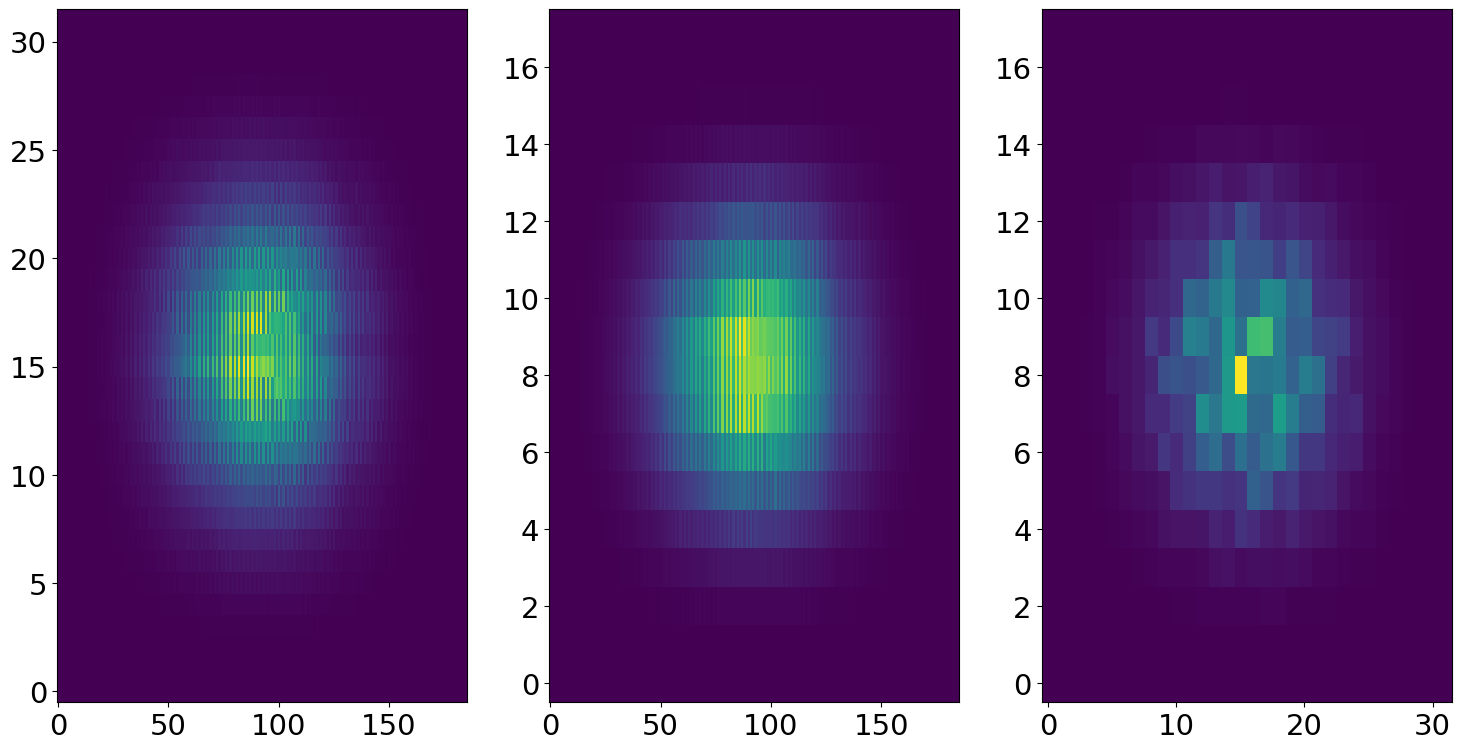

In [112]:
### Gridding sanity-check
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(
        mock.weights_1.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

Now we can calculate the mock cross after cleaning:

In [113]:
mock.k1dbins = ps.k1dbins
pcross_3d_c_cleaned = mock.cross_power_3d.copy()
pcross_1d_c_cleaned,keff_c,nmodes_c = mock.get_1d_power('cross_power_3d')

And compare with the mock cross without cleaning:

In [114]:
mock.data = hi_mock_map
mock.trim_map_to_range()
mock.taper_func = np.ones
mock.grid_data_to_field()
mock.taper_func = ps.taper_func
mock.apply_taper_to_field(1, axis=[0,1,2])
pcross_3d_c_noclean = mock.cross_power_3d.copy()
pcross_1d_c_noclean,keff_c,nmodes_c = mock.get_1d_power('cross_power_3d')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

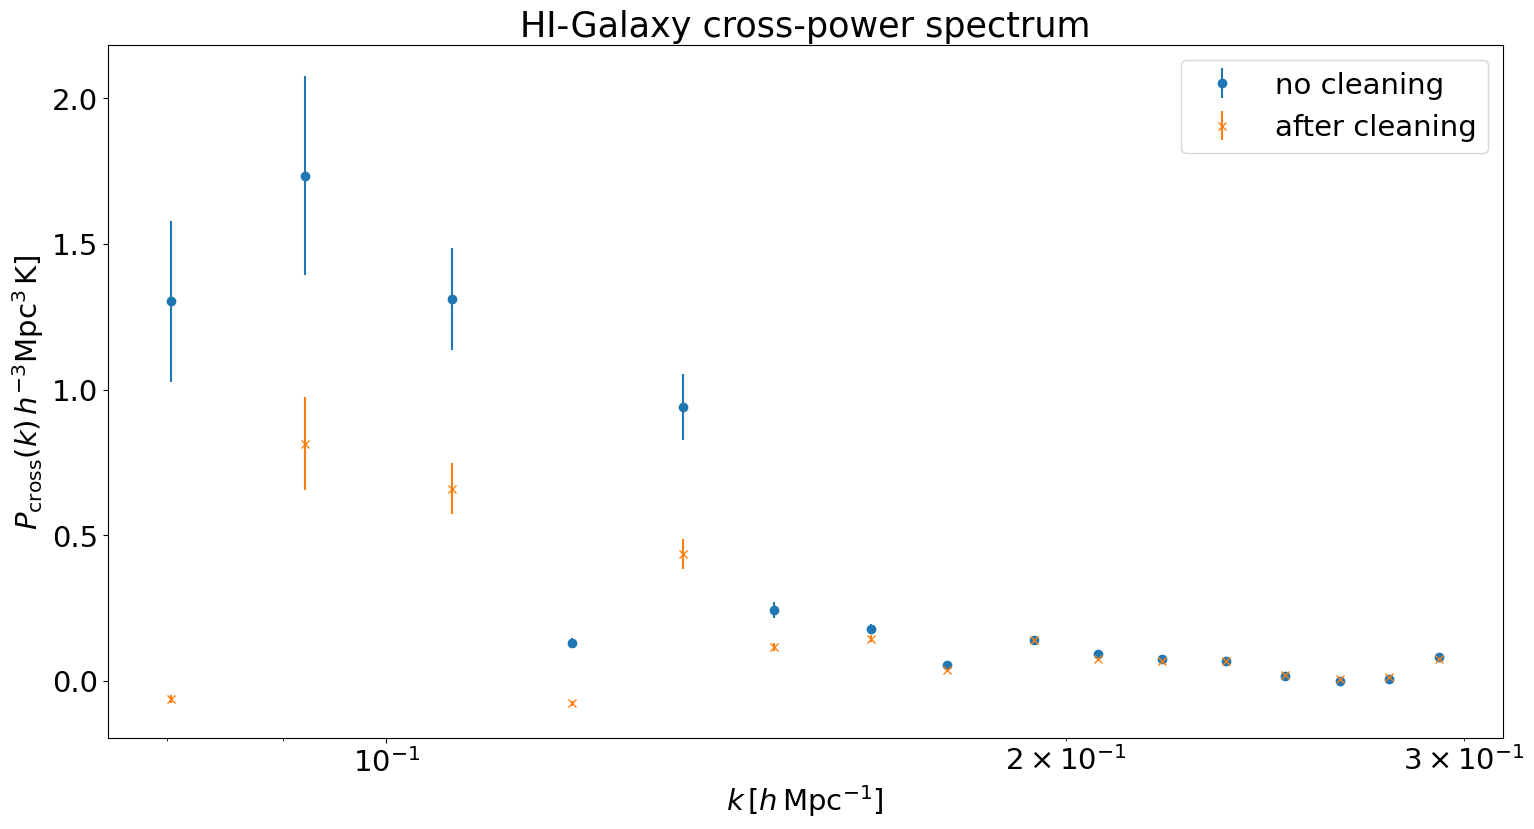

In [115]:

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(
    keff_c/ps.h,(pcross_1d_c_noclean)*ps.h**3,
    yerr=np.abs(pcross_1d_c_noclean)/np.sqrt(nmodes_c)*ps.h**3,
    ls='none',
    marker='o',
    label='no cleaning')
plt.errorbar(
    keff_c/ps.h,(pcross_1d_c_cleaned)*ps.h**3,
    yerr=np.abs(pcross_1d_c_cleaned)/np.sqrt(nmodes_c)*ps.h**3,
    ls='none',
    marker='x',
    label='after cleaning')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

All of these can be easily wrapped into a function (and run in parallel if you want):

In [129]:
def run_transfer_function(seed=None):
    mock = MockSimulation(
        ra_range = ra_range_MK,
        dec_range = dec_range_MK,
        tracer_bias_1 = bias_HI,
        tracer_bias_2 = bias_gal,
        downres_factor_radial=0.5, # highres in radial direction
        downres_factor_transverse=0.5, # highres in transverse direction
        box_buffkick=10,
        mean_amp_1='average_hi_temp',
        omegahi = omega_HI,
        sigma_beam_ch = sigma_ch,
        counts_file = counts_file,
        fits_file = fits_file,
        seed=seed,
    )
    # N_g_MK = N_g_GAMA * V_MK/V_GAMA
    num_g_MK = int(num_g_GAMA * mock.survey_volume / ps.survey_volume)
    # have large number of galaxies to isolate effect of HI
    mock.num_discrete_source = 1e5
    # generate HI temp map
    mock.data = mock.grid_field_to_sky_map(mock.mock_tracer_field_1)[0]
    # convolve it with the beam
    mock.convolve_data(mock.beam_image)
    # then reconvolve
    mock.convolve_data(reconv_beam_cube)
    # generate mock galaxy catalogue
    mock.propagate_mock_tracer_to_gal_cat()
    hi_mock_map = mock.data.copy()
    # combine the data
    mock.data = hi_mock_map + reconv_data
    mock.w_HI = reconv_weights
    # perform PCA
    clean_map, A_mat_mock = pcaclean(mock.data,N_fg,weights=mock.W_HI,mean_centre=True, return_A=True)
    R_mat_mock = np.eye(mock.nu.size) - A_mat_mock @ A_mat_mock.T
    hi_mock_mean_centered = (
        hi_mock_map - ((hi_mock_map * mock.W_HI).sum(-1) / mock.W_HI.sum(-1))[:,:,None]
    )
    hi_mock_cleaned = np.einsum('ij,abj->abi',R_mat_mock,hi_mock_mean_centered)
    mock.data = hi_mock_cleaned
    mock.ra_range = ra_range_GAMA
    mock.dec_range = dec_range_GAMA
    mock.trim_map_to_range()
    mock.trim_gal_to_range()
    mock.downres_factor_transverse = ps.downres_factor_transverse
    mock.downres_factor_radial = ps.downres_factor_radial
    mock.box_buffkick = ps.box_buffkick
    mock.grid_scheme = ps.grid_scheme
    mock.sampling_resol = ps.sampling_resol
    mock.compensate = ps.compensate
    mock.include_sky_sampling = ps.include_sky_sampling
    mock.taper_func = np.ones
    mock.grid_data_to_field()
    mock.grid_gal_to_field()
    mock.taper_func = ps.taper_func
    mock.apply_taper_to_field(1, axis=[0,1,2])
    pcross_3d_c_cleaned = mock.cross_power_3d.copy()
    mock.data = hi_mock_map
    mock.trim_map_to_range()
    mock.taper_func = np.ones
    mock.grid_data_to_field()
    mock.taper_func = ps.taper_func
    mock.apply_taper_to_field(1, axis=[0,1,2])
    pcross_3d_c_noclean = mock.cross_power_3d.copy()
    pcross_3d_c_model = mock.cross_power_tracer_model.copy()
    return pcross_3d_c_noclean, pcross_3d_c_cleaned, pcross_3d_c_model


In [133]:
%%capture
power_arr_noclean = []
power_arr_clean = []
power_arr_model = []
for i in range(100):
    power_1, power_2, power_3 = run_transfer_function(i)
    power_arr_noclean.append(power_1)
    power_arr_clean.append(power_2)
    power_arr_model.append(power_3)

In [172]:
transfer_function = np.array(power_arr_noclean).mean(0) / np.array(power_arr_clean).mean(0)

In [173]:
np.median(transfer_function)

0.9242183006567365

In [182]:
tf_1d_arr = []
for i in range(100):
    power_1d_noclean,_,_ = mock.get_1d_power(power_arr_noclean[i])
    power_1d_clean,_,_ = mock.get_1d_power(power_arr_clean[i])
    tf_1d_arr.append(power_1d_noclean / power_1d_clean)
tf_1d_arr = np.array(tf_1d_arr)

In [183]:
pdata_1d_cross_tf = tf_1d_arr * pdata_1d_cross[None]

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

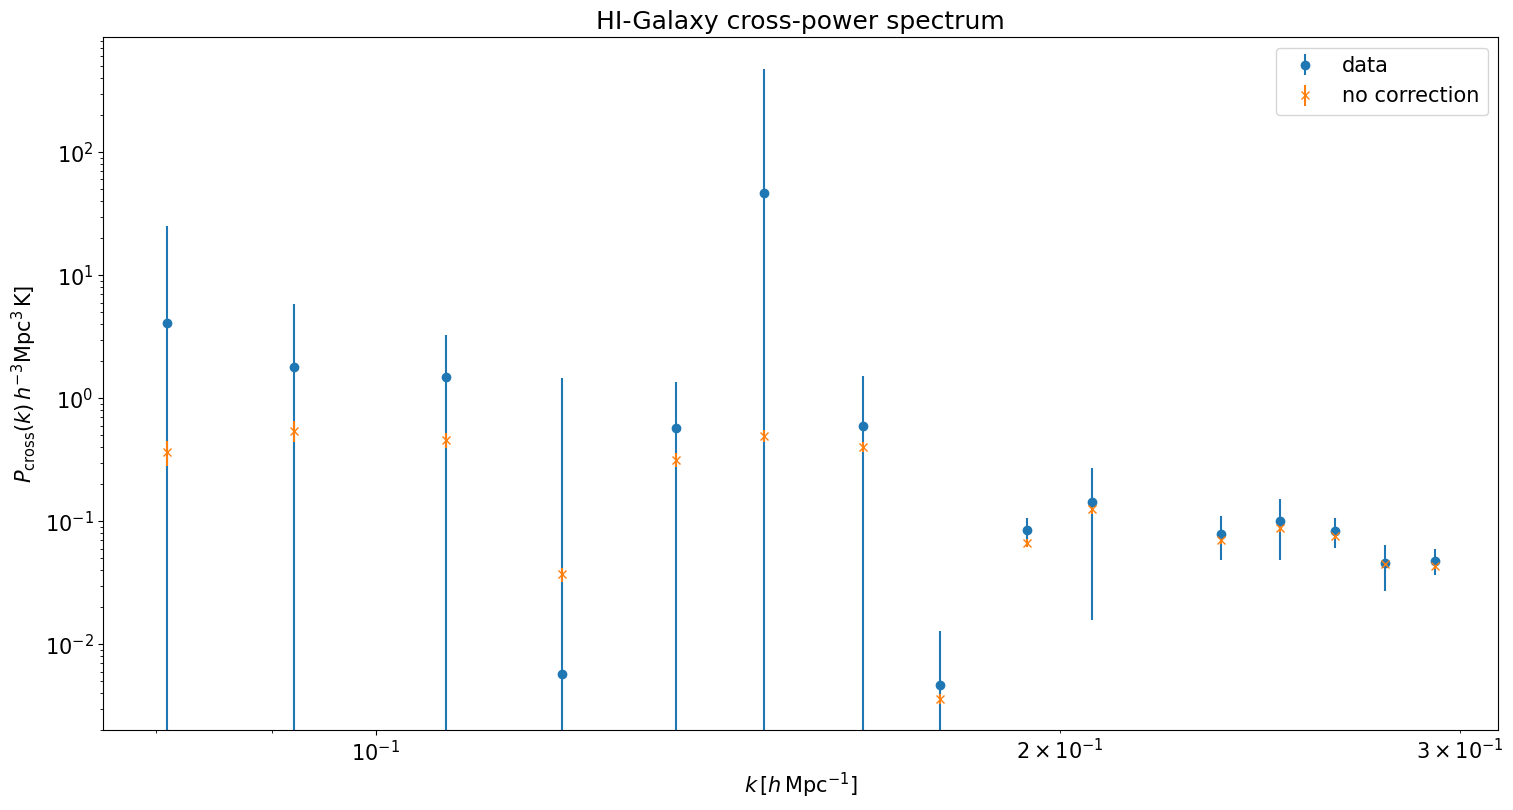

In [184]:
# a naive error bar 
perror_1d_c_tf = np.abs(pdata_1d_cross_tf)/np.sqrt(nmodes_c)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff_c/ps.h,(pdata_1d_cross_tf).mean(0)*ps.h**3,
             yerr=pdata_1d_cross_tf.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='data')

plt.errorbar(keff_c/ps.h,(pdata_1d_cross)*ps.h**3,
             yerr=perror_1d_c*ps.h**3,
             ls='none',
             marker='x',
             label='no correction')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

In [187]:
cov_1d = np.cov(tf_1d_arr.T)
corr_1d = np.corrcoef(tf_1d_arr.T)

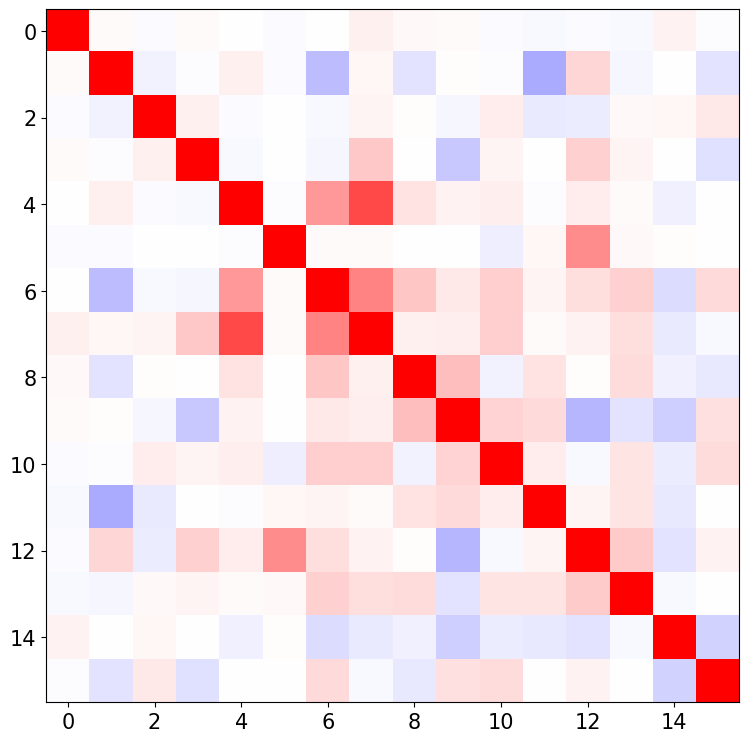

In [189]:
plt.imshow(corr_1d,vmin=-1,vmax=1,cmap='bwr')

Note that, this result is in the same order of magnitude as the fidual result, but with several aspects being different. This is for illustration and a more detailed replication is left for the paper draft.

## Step 8: Compare with model

You can change input model parameters in `ps` on the fly and recalculate model power spectrum with ease:

In [196]:
ps.tracer_bias_1 = bias_HI
ps.tracer_bias_2 = bias_gal
ps.omegahi = omega_HI
ps.cross_coeff = 0.9
ps.mean_amp_1 = 'average_hi_temp'

In [197]:
pmod_1d_gg,_,_ = ps.get_1d_power(ps.auto_power_tracer_2_model)
pmod_1d_c,_,_ = ps.get_1d_power(ps.cross_power_tracer_model)


Text(0.5, 1.0, 'Galaxy auto-power spectrum')

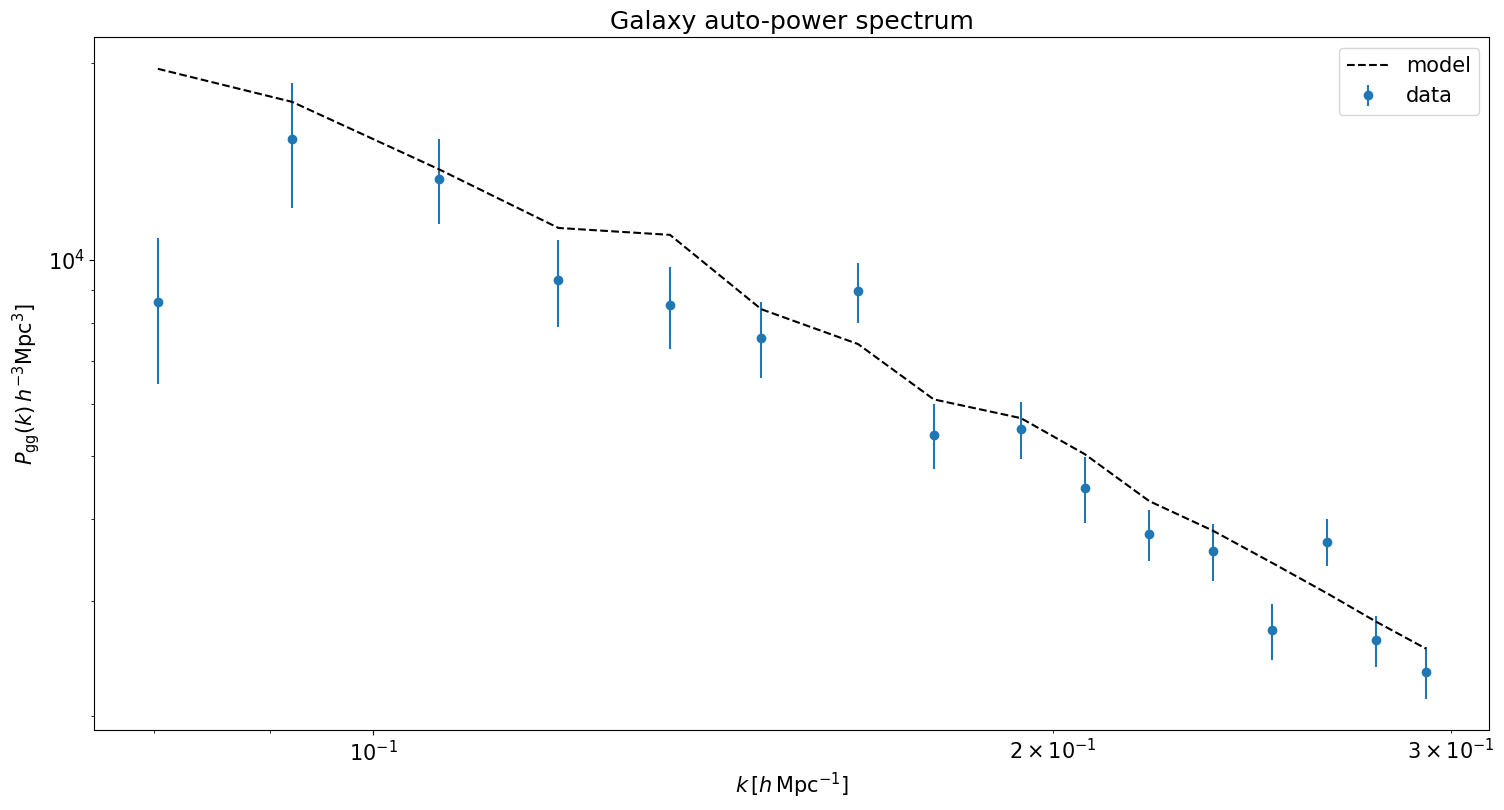

In [194]:
# a naive error bar 
perror_1d_gg = (pdata_1d_gg)/np.sqrt(nmodes)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff/ps.h,(pdata_1d_gg-psn)*ps.h**3,
             yerr=perror_1d_gg*ps.h**3,
             ls='none',
             marker='o',
             label='data')
plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model',ls='--',color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm gg}(k)\,h^{-3}{\rm Mpc}^3]$')
plt.title('Galaxy auto-power spectrum')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

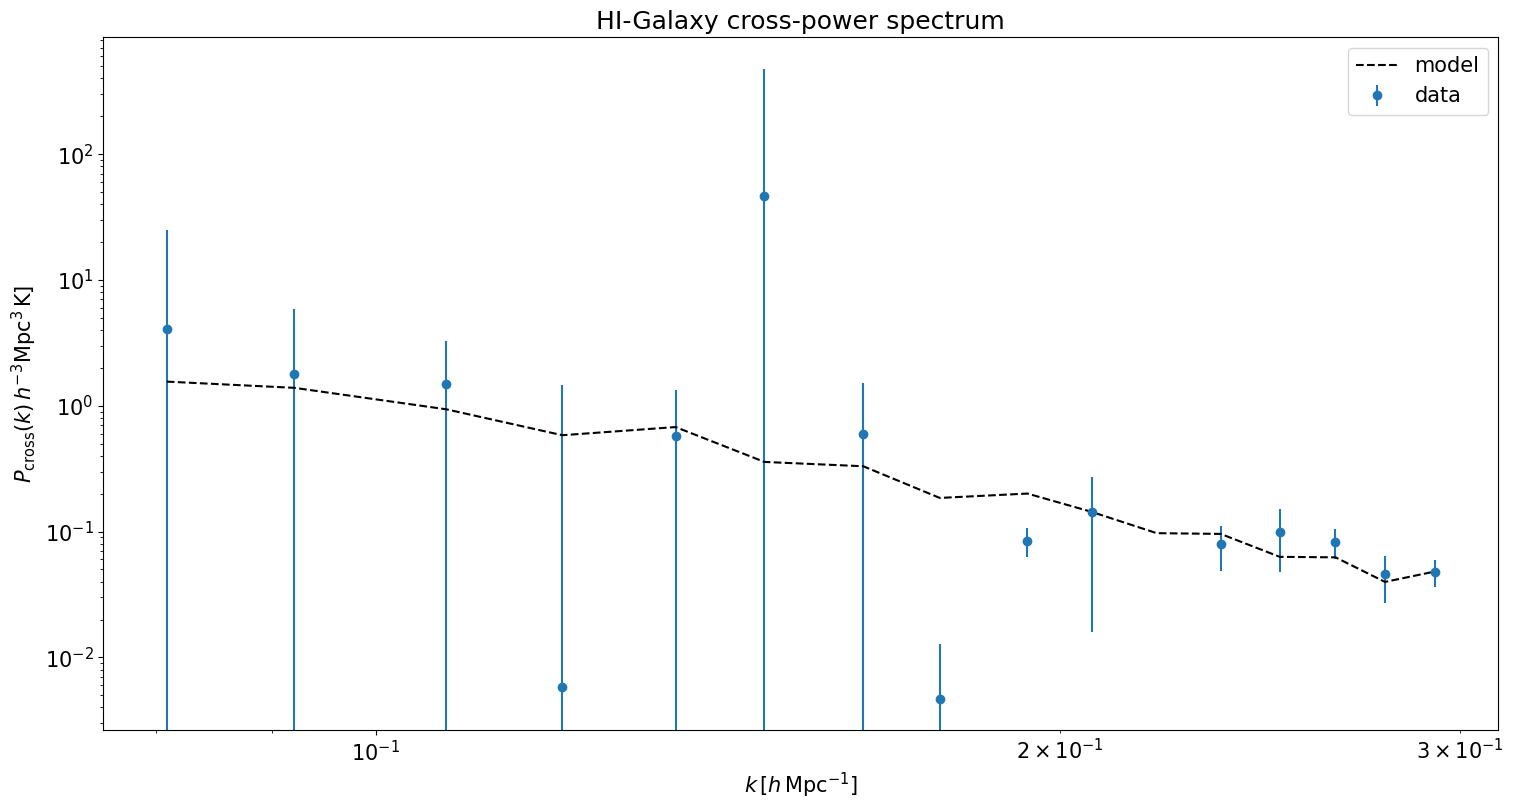

In [198]:
# a naive error bar 
perror_1d_c_tf = np.abs(pdata_1d_cross_tf)/np.sqrt(nmodes_c)

#plt.plot(keff/ps.h,pmod_1d_gg*ps.h**3,label='model')
plt.errorbar(keff_c/ps.h,(pdata_1d_cross_tf).mean(0)*ps.h**3,
             yerr=pdata_1d_cross_tf.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='data')
plt.plot(keff_c/ps.h,pmod_1d_c*ps.h**3,label='model',ls='--',color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')